# Case Study 3: Computational Methods in Finance

# Charles Laferte - cl4249

In [1]:
import modulesForCalibration as mfc

import warnings
warnings.filterwarnings("ignore")

import math
import numpy as np
import scipy.integrate as integrate
import pandas as pd

from scipy.optimize import fmin, fmin_bfgs

import cmath
import math

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
from tqdm import tqdm
from matplotlib import cm

## Import data

In [2]:
'''Standard & Poors 500 Index,Last: 4104.8301,Change:  -4.1099
Date: 12 avril 2023 √† 15:44 UTC‚àí4,Bid: 4104.1299,Ask: 4105.5498,Size: 1*1,Volume: 0'''

'Standard & Poors 500 Index,Last: 4104.8301,Change:  -4.1099\nDate: 12 avril 2023 √† 15:44 UTC‚àí4,Bid: 4104.1299,Ask: 4105.5498,Size: 1*1,Volume: 0'

Start_date

In [3]:
# Set the start date to compute the maturities
date_str = "2023-04-12"
# create a datetime object from the date string
start_date = datetime.strptime(date_str, "%Y-%m-%d")

Spot Price

In [4]:
S0 = 4104.8301

Rates

In [5]:
r = 0.0485

In [6]:
q = 0.0331026

Import market data

In [7]:
df_price = pd.read_csv("spx_3.csv", index_col=0)


In [8]:
#Filtrer les SPX... qui ne sont pas des SPXW...
#mask = df_price['Calls'].str.contains('SPXW', case=False, na=False)
#df_price = df_price[mask]

In [9]:
df_price.columns

Index(['Calls', 'Last Sale', 'Net', 'Bid', 'Ask', 'Volume', 'IV', 'Delta',
       'Gamma', 'Open Interest', 'Strike', 'Puts', 'Last Sale.1', 'Net.1',
       'Bid.1', 'Ask.1', 'Volume.1', 'IV.1', 'Delta.1', 'Gamma.1',
       'Open Interest.1'],
      dtype='object')

In [10]:
callPrices = df_price[['Strike']] #['Last Sale','Strike']]
# Compute the mid-price
callPrices['Price'] = np.abs(df_price['Bid'].array + df_price['Ask'].array)/2
# Convert index to datetime
callPrices.index = pd.to_datetime(callPrices.index)

# Getting the weights inversely proportional to bid-ask spread
callPrices['w'] = np.abs(1/(df_price['Bid'].array - df_price['Ask'].array))

# define a function to compute the difference in days between two dates
def date_diff(date):
    diff = (date - start_date)
    return diff.days

# create a new column in the DataFrame that contains the difference in days
callPrices['Maturity'] = callPrices.index.to_series().apply(date_diff)
callPrices['Maturity'] = callPrices['Maturity']/365.25
#callPrices['Strike'] = np.log(callPrices['Strike'].array)

callPrices = callPrices[callPrices['Strike']>=S0]

# drop today
callPrices = callPrices[callPrices['Maturity']!=0]
#579 avec zero mat included

In [11]:
putPrices = df_price[['Strike']] #['Last Sale','Strike']]
# Compute the mid-price
putPrices['Price'] = np.abs(df_price['Bid.1'].array + df_price['Ask.1'].array)/2
# Convert index to datetime
putPrices.index = pd.to_datetime(putPrices.index)

# Getting the weights inversely proportional to bid-ask spread
putPrices['w'] = np.abs(1/(df_price['Bid.1'].array - df_price['Ask.1'].array))

# define a function to compute the difference in days between two dates
def date_diff(date):
    diff = (date - start_date)
    return diff.days

# create a new column in the DataFrame that contains the difference in days
putPrices['Maturity'] = putPrices.index.to_series().apply(date_diff)
putPrices['Maturity'] = putPrices['Maturity']/365.25
#callPrices['Strike'] = np.log(callPrices['Strike'].array)

putPrices = putPrices[putPrices['Strike']<=S0]

# drop today
putPrices = putPrices[putPrices['Maturity']!=0]
#579 avec zero mat included

Visualize market data

In [12]:
callPrices

Strike   Price     w  Maturity
Expiration Date                                
2023-04-13       4105.0  16.350  10.0  0.002738
2023-04-13       4110.0  13.750  10.0  0.002738
2023-04-13       4115.0  11.400   5.0  0.002738
2023-04-13       4120.0   9.300   5.0  0.002738
2023-04-13       4125.0   7.450  10.0  0.002738
...                 ...     ...   ...       ...
2023-04-28       4580.0   0.075  20.0  0.043806
2023-04-28       4590.0   0.075  20.0  0.043806
2023-04-28       4600.0   0.075  20.0  0.043806
2023-04-28       4610.0   0.075  20.0  0.043806
2023-04-28       4620.0   0.075  20.0  0.043806

[542 rows x 4 columns]

In [13]:
putPrices

Strike   Price          w  Maturity
Expiration Date                                     
2023-04-13       3450.0   0.025  20.000000  0.002738
2023-04-13       3500.0   0.025  20.000000  0.002738
2023-04-13       3575.0   0.025  20.000000  0.002738
2023-04-13       3600.0   0.025  20.000000  0.002738
2023-04-13       3625.0   0.025  20.000000  0.002738
...                 ...     ...        ...       ...
2023-04-28       4080.0  38.250   3.333333  0.043806
2023-04-28       4085.0  39.950   3.333333  0.043806
2023-04-28       4090.0  41.650   3.333333  0.043806
2023-04-28       4095.0  43.500   2.500000  0.043806
2023-04-28       4100.0  45.400   2.500000  0.043806

[1102 rows x 4 columns]

In [14]:
callPrices.describe()

Strike       Price           w    Maturity
count   542.000000  542.000000  542.000000  542.000000
mean   4241.780443    9.665129    8.420357    0.024994
std     150.373269   12.544911    5.834118    0.013013
min    4105.000000    0.025000    2.000000    0.002738
25%    4155.000000    0.350000    3.333333    0.016427
50%    4210.000000    3.575000    6.666667    0.024641
75%    4285.000000   15.137500   10.000000    0.035592
max    6200.000000   55.650000   20.000000    0.043806

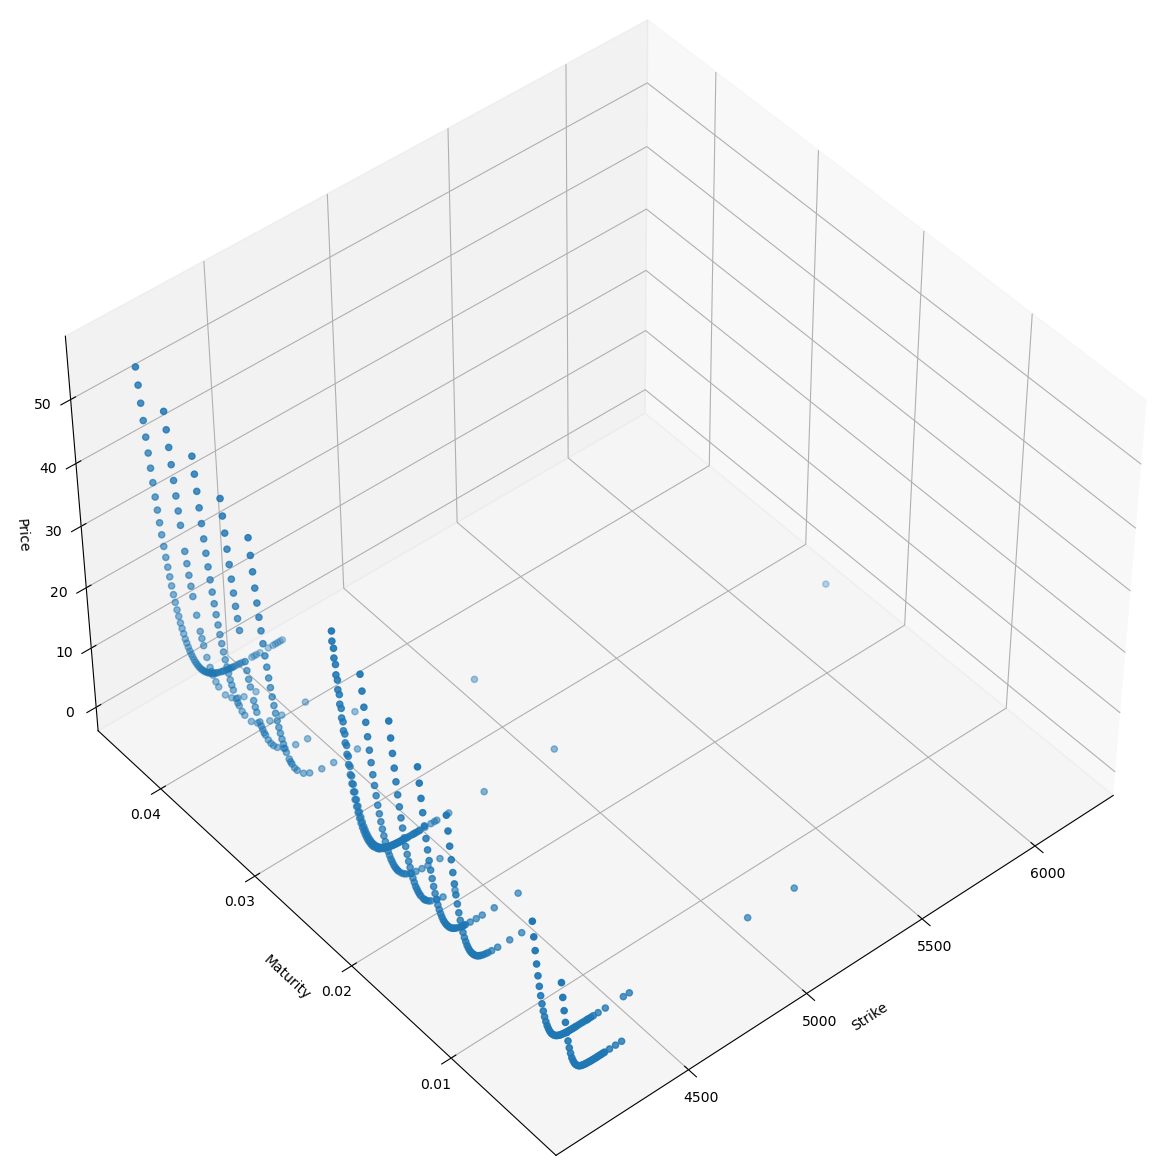

In [15]:
# create 3D scatter plot
fig = plt.figure(figsize= [15,15])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(callPrices['Strike'], callPrices['Maturity'], callPrices['Price'])#,s=50)
#ax.plot_surface(callPrices['Strike'], callPrices['Maturity'], callPrices['Price'], cmap=cm.coolwarm)
ax.view_init(elev=45, azim=230)
ax.set_xlabel('Strike')
ax.set_ylabel('Maturity')
ax.set_zlabel('Price')

plt.show()

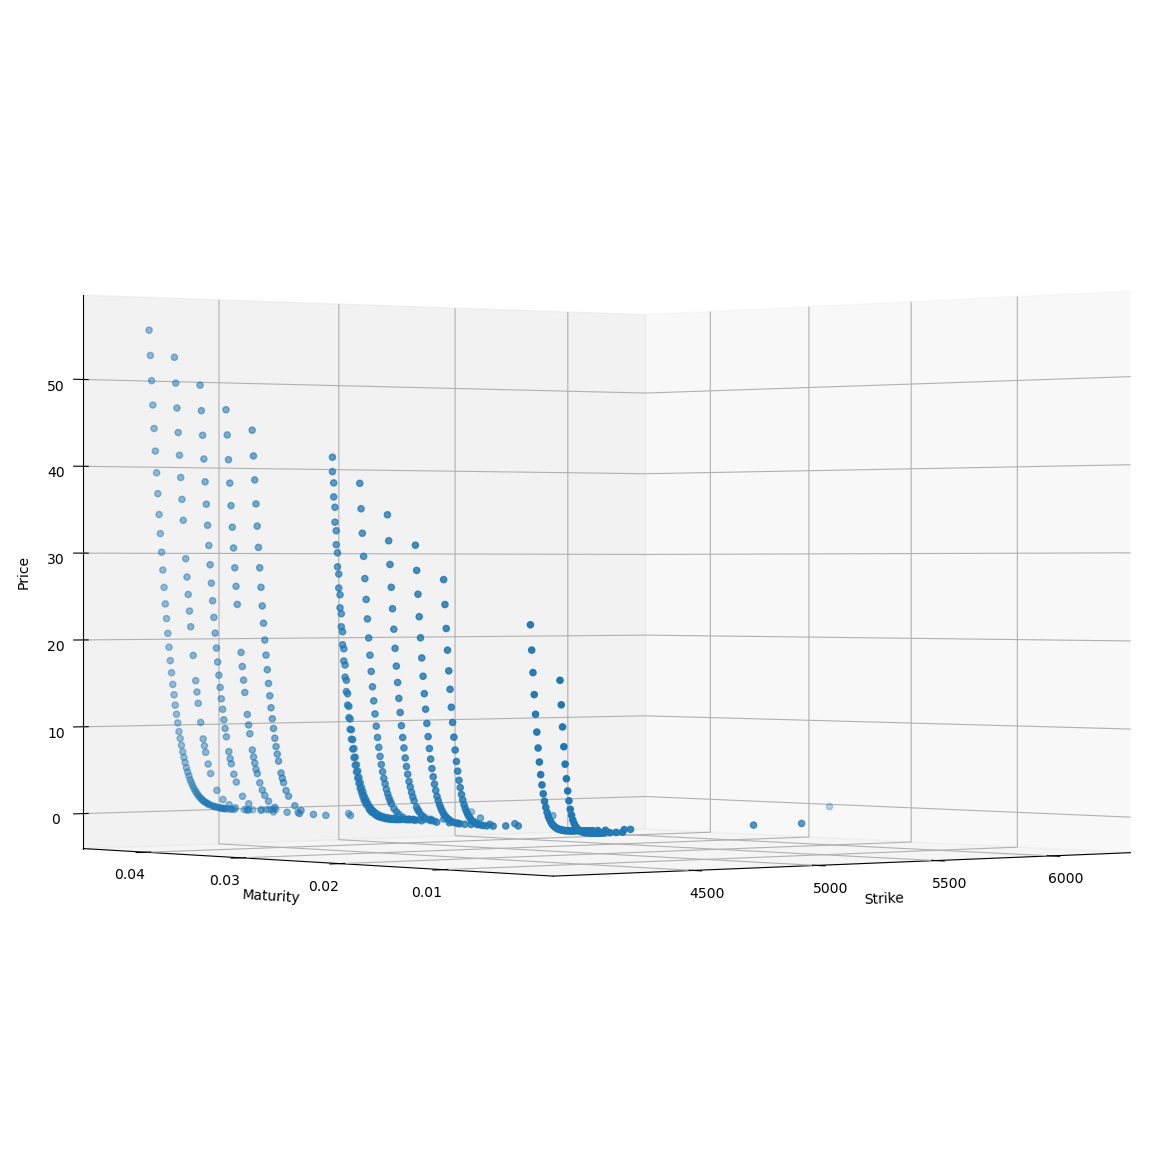

In [16]:
# create 3D scatter plot
fig = plt.figure(figsize= [15,15])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(callPrices['Strike'], callPrices['Maturity'], callPrices['Price'])#,s=50)
#ax.plot_surface(callPrices['Strike'], callPrices['Maturity'], callPrices['Price'], cmap=cm.coolwarm)
ax.view_init(elev=0, azim=230)
ax.set_xlabel('Strike')
ax.set_ylabel('Maturity')
ax.set_zlabel('Price')

plt.show()

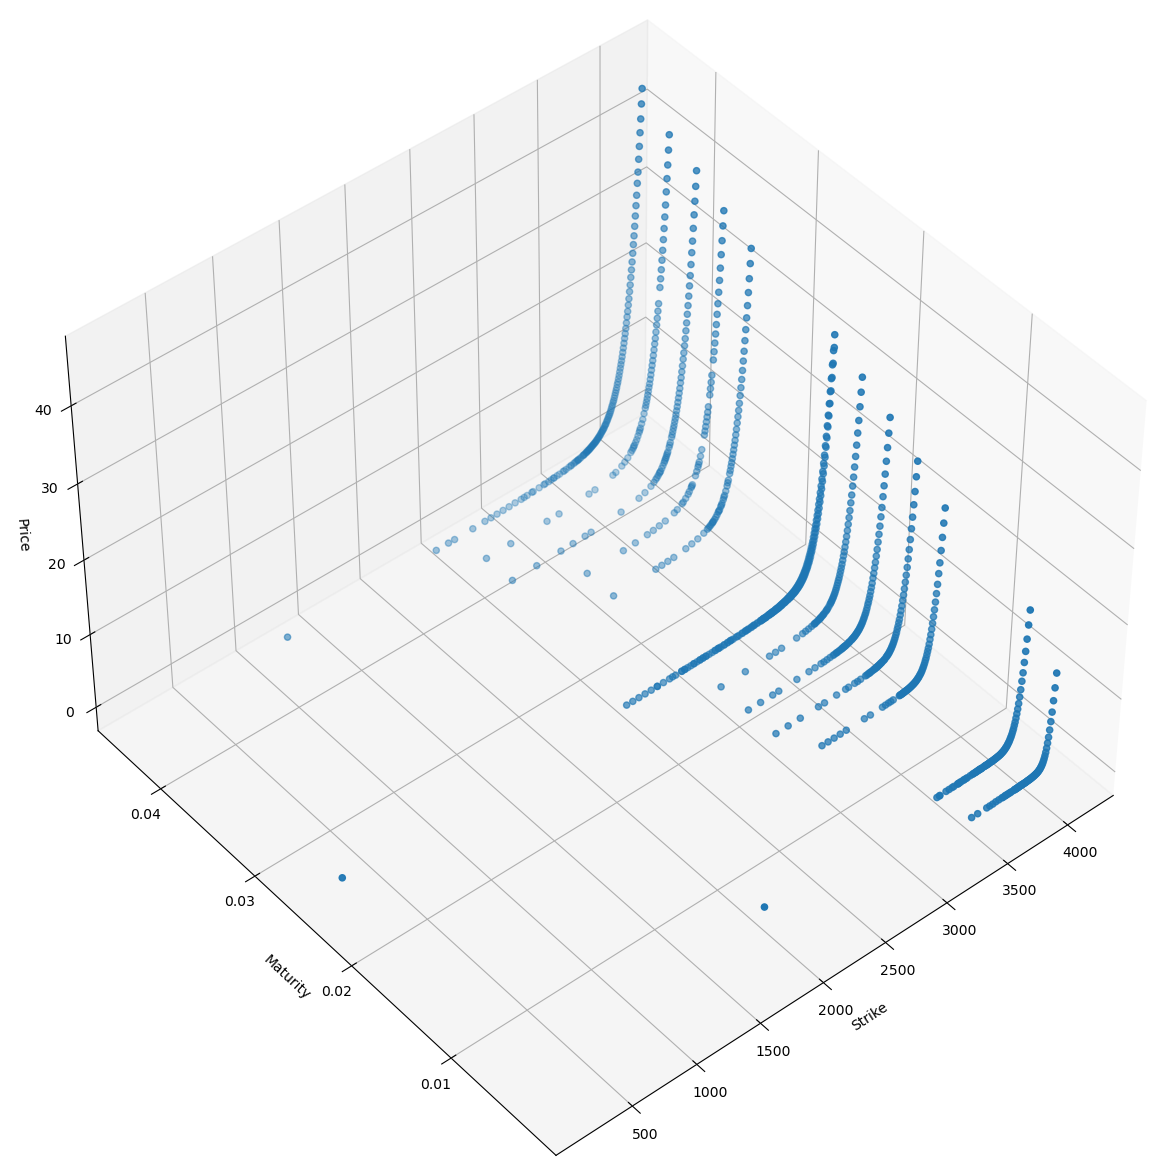

In [17]:
# create 3D scatter plot
fig = plt.figure(figsize= [15,15])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(putPrices['Strike'], putPrices['Maturity'], putPrices['Price'])#,s=50)
#ax.plot_surface(callPrices['Strike'], callPrices['Maturity'], callPrices['Price'], cmap=cm.coolwarm)
ax.view_init(elev=45, azim=230)
ax.set_xlabel('Strike')
ax.set_ylabel('Maturity')
ax.set_zlabel('Price')

plt.show()

### Building the marketprice matrix

In [18]:
strikes = pd.Series(callPrices['Strike'].unique()).sort_values().to_list()
maturities = pd.Series(callPrices['Maturity'].unique()).sort_values().to_list()
lenK = len(strikes)
lenT = len(maturities)

strike_m = []

#for i in strikes: 
for j in maturities: 
        #print(i, j)
        strike_m_temp = callPrices[(callPrices['Maturity']==j)]['Strike'].to_list()
        #marketPrices_temp = callPrices[(callPrices['Maturity']==j)]['Price'].to_list()
        
        #marketPrices.append(marketPrices_temp)
        strike_m.append(strike_m_temp)
        
strikes = set(strike_m[0])
for i in range(1,len(strike_m)):
    strikes = strikes.intersection(set(strike_m[i]))

strikes = list(strikes)
strikes = sorted(strikes)
print(strikes)

marketPrices = np.zeros((len(strikes), len(maturities)))
w = np.zeros((len(strikes), len(maturities)))
for j in range(len(maturities)):
    for i in range(len(strikes)):
        #print(maturities[j])
        #print(strikes[i])
        #print(callPrices[(callPrices['Maturity']== maturities[j]) & (callPrices['Strike']==strikes[i])]['Price'][0])
        marketPrices[i,j] = callPrices[(callPrices['Maturity']== maturities[j]) & (callPrices['Strike']==strikes[i])]['Price'][0]
        w[i,j] = callPrices[(callPrices['Maturity']== maturities[j]) & (callPrices['Strike']==strikes[i])]['w'][0]
        
marketPrices = marketPrices.T
w = w.T

[4105.0, 4110.0, 4115.0, 4120.0, 4125.0, 4130.0, 4135.0, 4140.0, 4150.0, 4165.0, 4170.0, 4180.0, 4190.0, 4195.0, 4200.0, 4210.0, 4220.0, 4225.0, 4230.0, 4240.0, 4250.0, 4275.0, 4300.0, 4350.0]


In [19]:
strikes_p = pd.Series(putPrices['Strike'].unique()).sort_values().to_list()
maturities_p = pd.Series(putPrices['Maturity'].unique()).sort_values().to_list()
lenK_p = len(strikes_p)
lenT_p = len(maturities_p)

strike_m_p = []

#for i in strikes: 
for j in maturities_p: 
        #print(i, j)
        strike_m_temp_p = putPrices[(putPrices['Maturity']==j)]['Strike'].to_list()
        #marketPrices_temp = callPrices[(callPrices['Maturity']==j)]['Price'].to_list()
        
        #marketPrices.append(marketPrices_temp)
        strike_m_p.append(strike_m_temp_p)
        
strikes_p = set(strike_m_p[0])
for i in range(1,len(strike_m_p)):
    strikes_p = strikes_p.intersection(set(strike_m_p[i]))

strikes_p = list(strikes_p)
strikes_p = sorted(strikes_p)
#print(strikes_p)
#print(maturities_p)
marketPrices_p = np.zeros((len(strikes_p), len(maturities_p)))
w_p = np.zeros((len(strikes_p), len(maturities_p)))
for j in range(len(maturities_p)):
    for i in range(len(strikes_p)):
        #print(maturities_p[j])
        #print(strikes_p[i])
        #print(putPrices[(putPrices['Maturity']== maturities_p[j]) & (putPrices['Strike']==strikes_p[i])]['Price'][0])
        marketPrices_p[i,j] = putPrices[(putPrices['Maturity']== maturities_p[j]) & (putPrices['Strike']==strikes_p[i])]['Price'][0]
        w_p[i,j] = putPrices[(putPrices['Maturity']== maturities_p[j]) & (putPrices['Strike']==strikes_p[i])]['w'][0]
        
marketPrices_p = marketPrices_p.T
w_p = w_p.T

# 1. Heston and VGSA parameters via calibration 

In [20]:
#Generating Option Price Surface Under A model from the list         
def generic_CF(u, params, T, model):
    
    if (model == 'GBM'):
        
        sig = params[0];
        mu = np.log(S0) + (r-q-sig**2/2)*T;
        a = sig*np.sqrt(T);
        phi = np.exp(1j*mu*u-(a*u)**2/2);
        
    elif(model == 'Heston'):
        
        kappa  = params[0];
        theta  = params[1];
        sigma  = params[2];
        rho    = params[3];
        v0     = params[4];

        tmp = (kappa-1j*rho*sigma*u);
        g = np.sqrt((sigma**2)*(u**2+1j*u)+tmp**2);
        
        pow1 = 2*kappa*theta/(sigma**2);

        numer1 = (kappa*theta*T*tmp)/(sigma**2) + 1j*u*T*r + 1j*u*math.log(S0); # manque un q ici en fait (dans le python file)
        log_denum1 = pow1 * np.log(np.cosh(g*T/2)+(tmp/g)*np.sinh(g*T/2));
        tmp2 = ((u*u+1j*u)*v0)/(g/np.tanh(g*T/2)+tmp);
        log_phi = numer1 - log_denum1 - tmp2;
        phi = np.exp(log_phi);

    elif (model == 'VG'):
        
        sigma  = params[0];
        nu     = params[1];
        theta  = params[2];

        if (nu == 0):
            mu = math.log(S0) + (r-q - theta -0.5*sigma**2)*T;
            phi  = math.exp(1j*u*mu) * math.exp((1j*theta*u-0.5*sigma**2*u**2)*T);
        else:
            mu  = math.log(S0) + (r-q + math.log(1-theta*nu-0.5*sigma**2*nu)/nu)*T;
            phi = cmath.exp(1j*u*mu)*((1-1j*nu*theta*u+0.5*nu*sigma**2*u**2)**(-T/nu));
            
    elif (model == 'VGSA'):
        
        sigma  = params[0];
        nu     = params[1];
        theta  = params[2];
        kappa  = params[3]; 
        eta    = params[4];
        lbda   = params[5];
        
        #cf if mu = 0 ce qu'on fait
        #if (nu == 0):
        psi_VG_i = - np.log(1-theta*nu-sigma**2*nu*0.5)/nu
        psi_VG_u = - np.log(1-1j*u*theta*nu+sigma**2*nu*u**2*0.5)/nu
        
        tp = 1j*u * (np.log(S0) + (r-q)*T)
        
        def A(v):
            ga = np.sqrt(kappa**2 - 2*lbda**2*1j*v)
            A_t_u = np.exp(kappa**2*eta*T/(lbda**2))/((np.cosh(ga*T/2)+(kappa/ga)*np.sinh(ga*T/2))**(kappa*2*eta/(lbda**2)))
            return(A_t)
        def B(v):
            ga = np.sqrt(kappa**2 - 2*lbda**2*1j*v)
            B_t = 2*1j*v / (kappa+ ga/np.tanh(ga*T/2))
            return(B_t)
        
        A_t_u = np.exp(kappa**2*eta*T/(lbda**2))/((np.cosh(ga*T/2)+(kappa/ga)*np.sinh(ga*T/2))**(kappa*2*eta/(lbda**2)))
        B_t_u = 2*1j*u / (kappa+ ga/np.tanh(ga*T/2))
        
        phi_up = A(-1j*psi_VG_u)*np.exp(B(-j*psi_VG_u)/nu)
        phi_down = A(-1j*psi_VG_i)*np.exp(B(-j*psi_VG_i)/nu)
        
        phi = np.exp(tp)*phi_up/phi_down
        
    return phi

In [21]:
def genericFFT(params, T, model):
    
    # forming vector x and strikes km for m=1,...,N
    km = []
    xX = []
    
    # discount factor
    df = math.exp(-r*T)
    
    for j in range(N):
        
        nuJ=j*eta
        km.append(beta+j*lda)
        
        psi_nuJ = df*generic_CF(nuJ-(alpha+1)*1j, params, T, model)/((alpha + 1j*nuJ)*(alpha+1+1j*nuJ))
        if j == 0:
            wJ = (eta/2)
        else:
            wJ = eta
        
        xX.append(cmath.exp(-1j*beta*nuJ)*psi_nuJ*wJ)
     
    yY = np.fft.fft(xX)
    
    cT_km = []    
    for i in range(N):
        multiplier = math.exp(-alpha*km[i])/math.pi
        cT_km.append(multiplier*np.real(yY[i]))
    
    return km, cT_km


In [22]:
# function for the search: 
def myRange(start, finish, increment):
    while (start <= finish):
        yield start
        start += increment
        
def objFunc(v, x0, x1, x2):
    # Paraboloid centered on (x, y), with scale factors (10, 20) and minimum 30
    return 10.0*(v[0]-x0)**2 + 20.0*(v[1]-x1)**2 + 30.0*(v[2]-x2)**2 + 40.0

Here, for calibration, we will use Gradient-Based routines e.g. the Broyden-Fletcher-Goldfarb-Shanno (BFGS) algorithm.

# 1.1 Heston model:

#### Parameters
κ is the mean reversion speed, 
θ is the long run variance,
σ is the volatility of the volatility.

## 1.1.a Heston with equal weights on Call Prices

In [26]:
params = [2.3,     0.046,   0.0825, -0.53,    0.054]
# Parameters
alpha = 1.5
eta = 0.2
n = 12

model ='Heston'

def callbackF(xi):
    global num_iter
    global arg
    print(' ')
    print('i = ' + str(num_iter))
    print('x_i = ' + str(xi))
    print('f_i = ' + str(mfc.eValue(xi, *arg)))
    num_iter += 1

arg = (marketPrices, maturities, strikes, r, q, S0, alpha, eta, n, model)

num_iter = 1
[xopt, fopt, gopt, Bopt, func_calls, grad_calls, warnflg] = fmin_bfgs(
        mfc.eValue,
        params,
        args=arg, 
        fprime=None,
        callback=callbackF,
        maxiter=20,
        full_output=True, 
        retall=False)

20.460925548001136
20.4609255471264
20.460925814420616
20.46092551868241
20.460925552170313
20.46093247397318
4.217451315627437
4.21745131313313
4.2174516556463315
4.217451280338625
4.217451320959171
4.21746008558187
41.376268156635845
41.37626816074024
41.376267955454466
41.3762681307793
41.376268161171225
41.376262888675775
80.42606258550792
80.42606257504757
80.426062447013
80.42606256399561
80.42606258900518
80.4260589147582
39.72400194276201
39.72400193548118
39.72400173804005
39.7240019166749
39.7240019467634
39.72399657007261
71.72544436994127
71.72544435708501
71.72544422124963
71.72544434776778
71.72544437331777
71.72544043386222
5.721214167026973
5.72121416393174
5.721214506139536
5.721214132497497
5.721214172215313
5.721205403760039
10.971538181273038
10.971538181040794
10.971537594672071
10.97153820829175
10.971538177543902
10.971523157571378
1.6562605853444008
1.656260584606369
1.6562607270572673
1.6562605586508572
1.6562605897005047
1.6562642077007304
 
i = 1
x_i = [ 2.30

1.157872213402206
1.1578722110367592
1.1578722141799398
1.1578722131532275
1.1578722095418275
 
i = 18
x_i = [ 2.27244612 -0.04872989  0.6        -0.66850261 -0.96031431]
1.1578722133694364
f_i = 1.1578722133694364
1.1578447554939566
1.1578447555285283
1.1578447530213078
1.1578447540713863
1.1578447553270594
1.1578447577184914
 
i = 19
x_i = [ 2.27302742 -0.04856813  0.59996655 -0.66807358 -0.96030877]
1.1578447554939566
f_i = 1.1578447554939566
1.1577922913522154
1.157792291386345
1.1577922888924521
1.157792289894397
1.1577922912420833
1.1577922983775482
 
i = 20
x_i = [ 2.27361403 -0.04827659  0.59998765 -0.66736729 -0.96029888]
1.1577922913522154
f_i = 1.1577922913522154
         Current function value: 1.157792
         Iterations: 20
         Function evaluations: 348
         Gradient evaluations: 58


In [27]:
xopt

array([ 2.27361403, -0.04827659,  0.59998765, -0.66736729, -0.96029888])

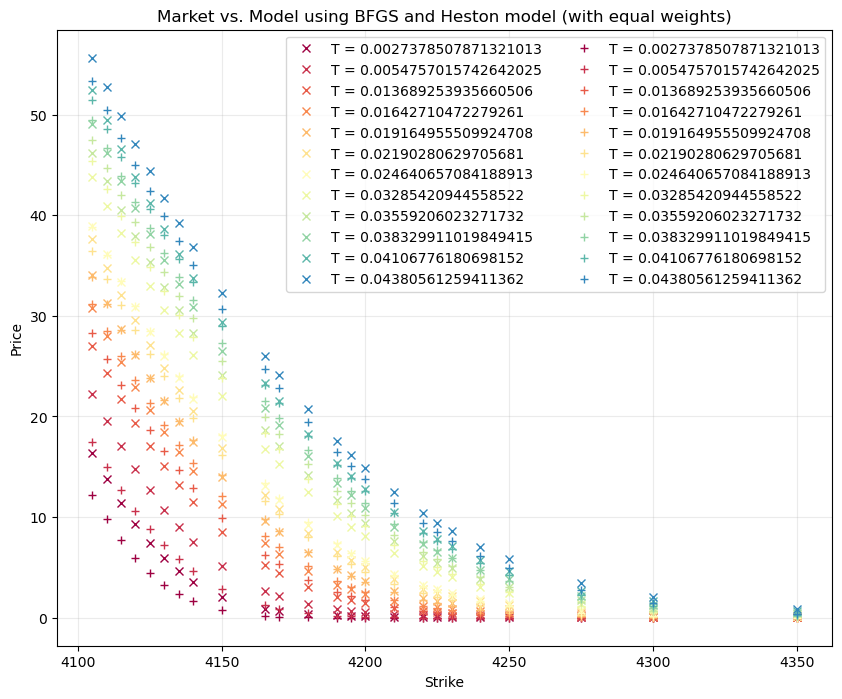

In [28]:
params2 = xopt
lenT = len(maturities)
lenK = len(strikes)
modelPrices = np.zeros((lenT, lenK))

for i in range(lenT):
    for j in range(lenK):
        T = maturities[i]
        K = strikes[j]
        [km, cT_km] = mfc.genericFFT(params2, S0, K, r, q, T, alpha, eta, n, model)
        modelPrices[i,j] = cT_km[0]


# plot
fig = plt.figure(figsize=(10,8))
labels = []
colormap = cm.Spectral
# create a list of colors to cycle through
colors = [colormap(i) for i in np.linspace(0, 0.9, len(maturities))]

#plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, len(maturities))])
plt.gca().set_prop_cycle(color=colors)
for i in range(len(maturities)):
    plt.plot(strikes, marketPrices[i,:], 'x')
    labels.append('T = ' + str(maturities[i]))
    
for i in range(len(maturities)):
    plt.plot(strikes, modelPrices[i,:], '+')
    labels.append('T = ' + str(maturities[i]))
plt.legend(labels, loc='upper right', ncol=2)
plt.grid(alpha=0.25)
plt.xlabel('Strike')
plt.ylabel('Price')
plt.title('Market vs. Model using BFGS and Heston model (with equal weights)')
plt.savefig('MarketvsModel_BFGS.png')
plt.show() 


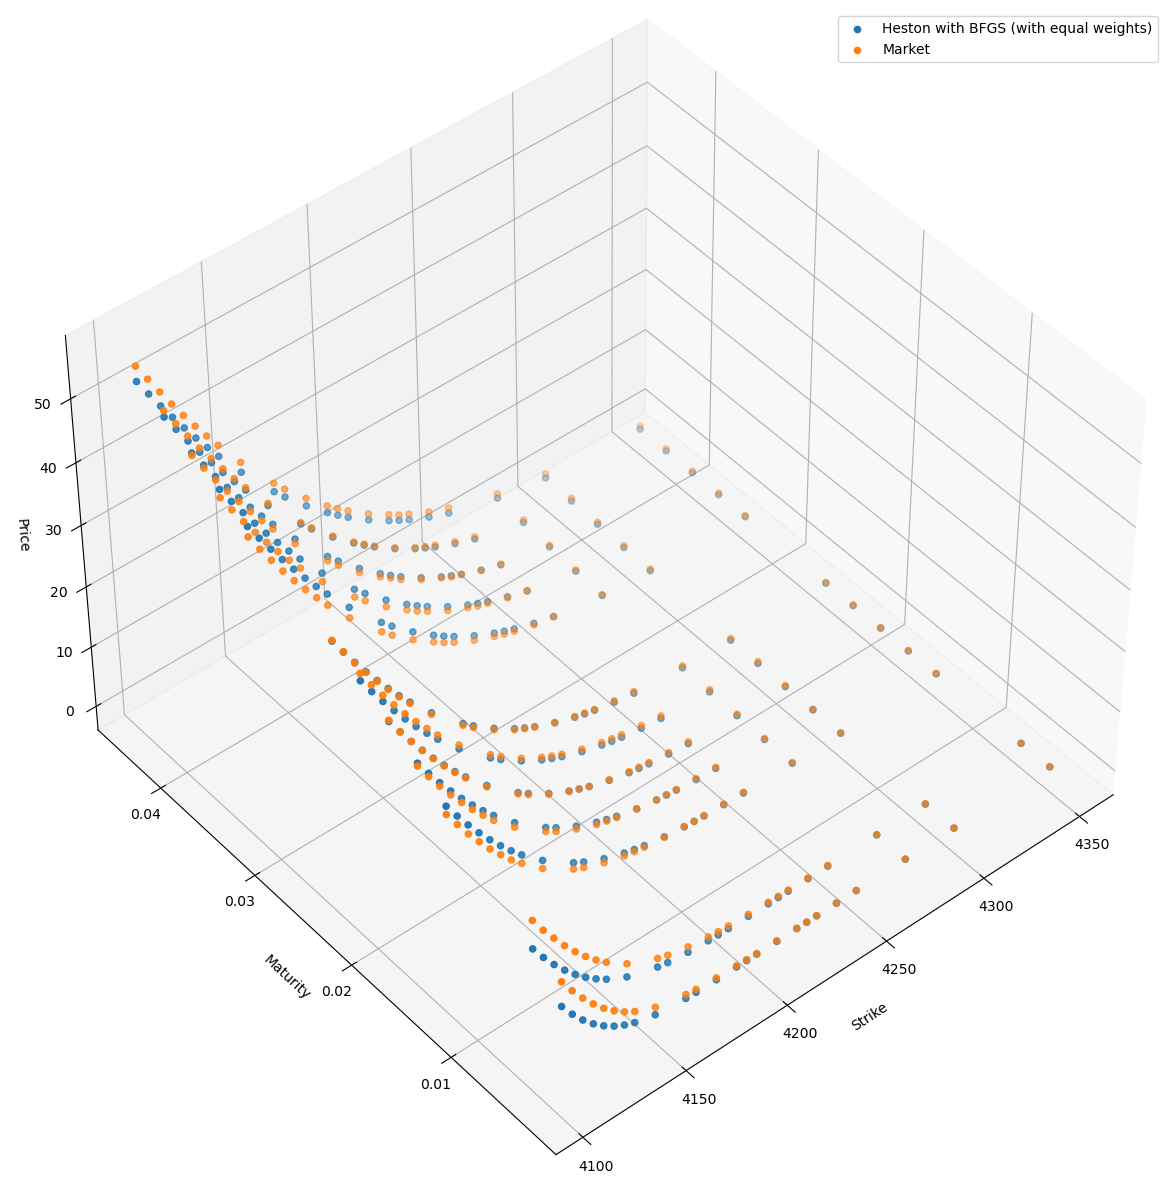

In [29]:
# create a meshgrid of the maturities and strikes
maturities_, strikes_ = np.meshgrid(maturities, strikes)

maturities_flat = maturities_.flatten()
strikes_flat =  strikes_.flatten()
prices_flat =  marketPrices.flatten()


fig = plt.figure(figsize= [15,15])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(strikes_flat, maturities_flat, modelPrices.T, label='Heston with BFGS (with equal weights)')
ax.scatter(strikes_, maturities_, marketPrices.T, label='Market')
ax.view_init(elev=45, azim=230)
ax.set_xlabel('Strike')
ax.set_ylabel('Maturity')
ax.set_zlabel('Price')
ax.set_title('Market vs. Model using BFGS and Heston model (with equal weights)')
plt.legend()

plt.show()

!!!!!!!!!!!!!!!!!!!!!!!! Short maturity messy market point both the model is not enough some vol shit and leads to convergence difficult for the parameters


## 1.1.b Heston with weights inversely proportional to bid-ask spread on Call prices

In [30]:
params = [2.3,     0.046,   0.0825, -0.53,    0.054]
# Parameters
alpha = 1.5
eta = 0.2
n = 12

model ='Heston'

def callbackF_w(xi):
    global num_iter
    global arg
    print(' ')
    print('i = ' + str(num_iter))
    print('x_i = ' + str(xi))
    print('f_i = ' + str(mfc.eValue_w(xi, *arg)))
    num_iter += 1

arg = (marketPrices, maturities, strikes, r, q, S0, alpha, eta, n, model, w)

num_iter = 1
[xopt_w, fopt_w, gopt_w, Bopt_w, func_calls_w, grad_calls_w, warnflg_w] = fmin_bfgs(
        mfc.eValue_w,
        params,
        args=arg, 
        fprime=None,
        callback=callbackF_w,
        maxiter=20,
        full_output=True, 
        retall=False)

15.421483335524792
15.421483334877848
15.421483533852268
15.421483307550877
15.421483339620798
15.421488708067281
3.20116918050907
3.201169178909324
3.201169421678142
3.201169150517351
3.2011691852194457
3.2011754687462584
31.939293981335243
31.939293983959193
31.939293827344937
31.9392939552068
31.939293986270233
31.939289722477383
58.186131829739374
58.18613182235504
58.18613171536493
58.18613180673998
58.18613183367504
58.186135073028446
30.926759703623066
30.92675969736876
30.9267595479153
30.926759677388052
30.926759707788325
30.926764023939604
18.72095447547407
18.720954470825166
18.720954662392046
18.72095444754243
18.720954479821646
18.720949368908443
6.974765942045963
6.974765941794522
6.9747655796385635
6.974765961929663
6.97476593913611
6.974756321881496
1.400451296459661
1.4004512960203357
1.4004513950455078
1.4004512767236947
1.4004512997556655
1.4004535357779522
 
i = 1
x_i = [ 2.30012216  0.00855063  0.0877822  -0.53077343 -0.9604754 ]
1.400451296459661
f_i = 1.400451296

1.0553783042288474
1.0552812913848626
1.0552812913522076
1.0552812862980194
1.055281293160282
1.055281291163649
1.0552815273845182
1.0552714368869205
1.0552714368545124
1.055271431930345
1.055271438638473
1.0552714366446956
1.055271669860913
1.0552702750553555
1.055270275023072
1.0552702701143772
1.055270276804118
1.0552702748106784
1.0552705076673814
1.0552701356244254
1.055270135592069
1.055270130685342
1.0552701373728388
1.0552701353794116
1.0552703681929119
1.0552701189127989
1.0552701188805056
1.055270113974127
1.0552701206610082
1.0552701186678093
1.0552703514759838
1.0552701184740083
1.055270118441786
1.0552701135352813
1.055270119100045
1.0552701182291055
1.0552703510369956
 
i = 11
x_i = [ 2.30266085 -0.01013561  0.6        -0.66828337 -0.95851361]
1.0552701184740083
f_i = 1.0552701184740083
1.0552701163940355
1.0552701163617886
1.0552701114552434
1.0552701170199106
1.0552701161489981
1.055270348956862
1.0552701080738647
1.0552701080415707
1.0552701031351954
1.0552701086993308

In [31]:
xopt_w

array([ 2.31285613, -0.01611033,  0.59999966, -0.65370581, -0.95888835])

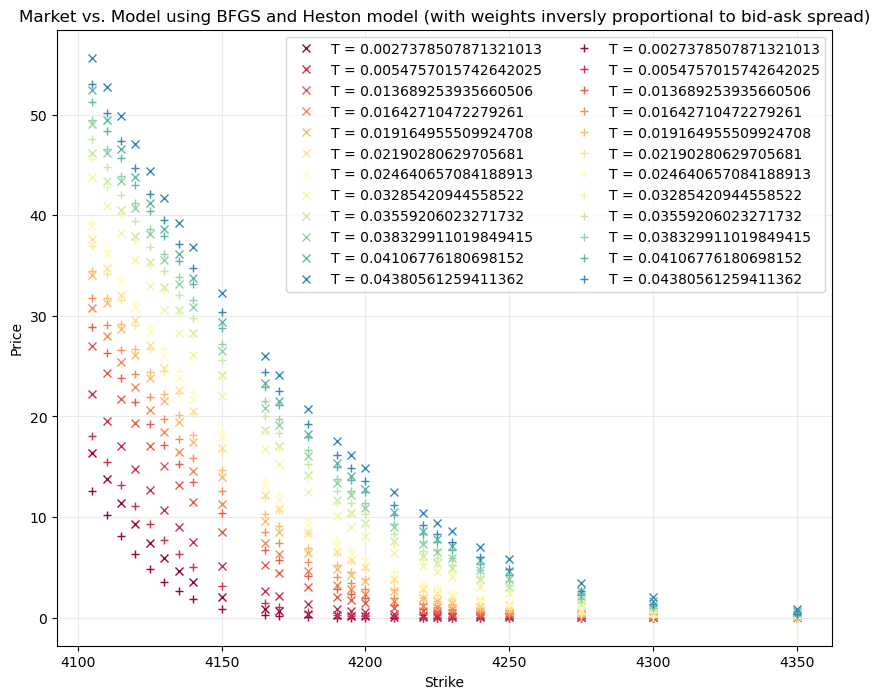

In [32]:
params2 = xopt_w
lenT = len(maturities)
lenK = len(strikes)
modelPrices_w = np.zeros((lenT, lenK))

for i in range(lenT):
    for j in range(lenK):
        T = maturities[i]
        K = strikes[j]
        [km, cT_km] = mfc.genericFFT(params2, S0, K, r, q, T, alpha, eta, n, model)
        modelPrices_w[i,j] = cT_km[0]

# plot
fig = plt.figure(figsize=(10,8))
labels = []
colormap = cm.Spectral
# create a list of colors to cycle through
colors = [colormap(i) for i in np.linspace(0, 0.9, len(maturities))]

#plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, len(maturities))])
plt.gca().set_prop_cycle(color=colors)
for i in range(len(maturities)):
    plt.plot(strikes, marketPrices[i,:], 'x')
    labels.append('T = ' + str(maturities[i]))
    
for i in range(len(maturities)):
    plt.plot(strikes, modelPrices_w[i,:], '+')
    labels.append('T = ' + str(maturities[i]))
plt.legend(labels, loc='upper right', ncol=2)
plt.grid(alpha=0.25)
plt.xlabel('Strike')
plt.ylabel('Price')
plt.title('Market vs. Model using BFGS and Heston model (with weights inversly proportional to bid-ask spread)')
plt.savefig('MarketvsModel_BFGS.png')
plt.show() 


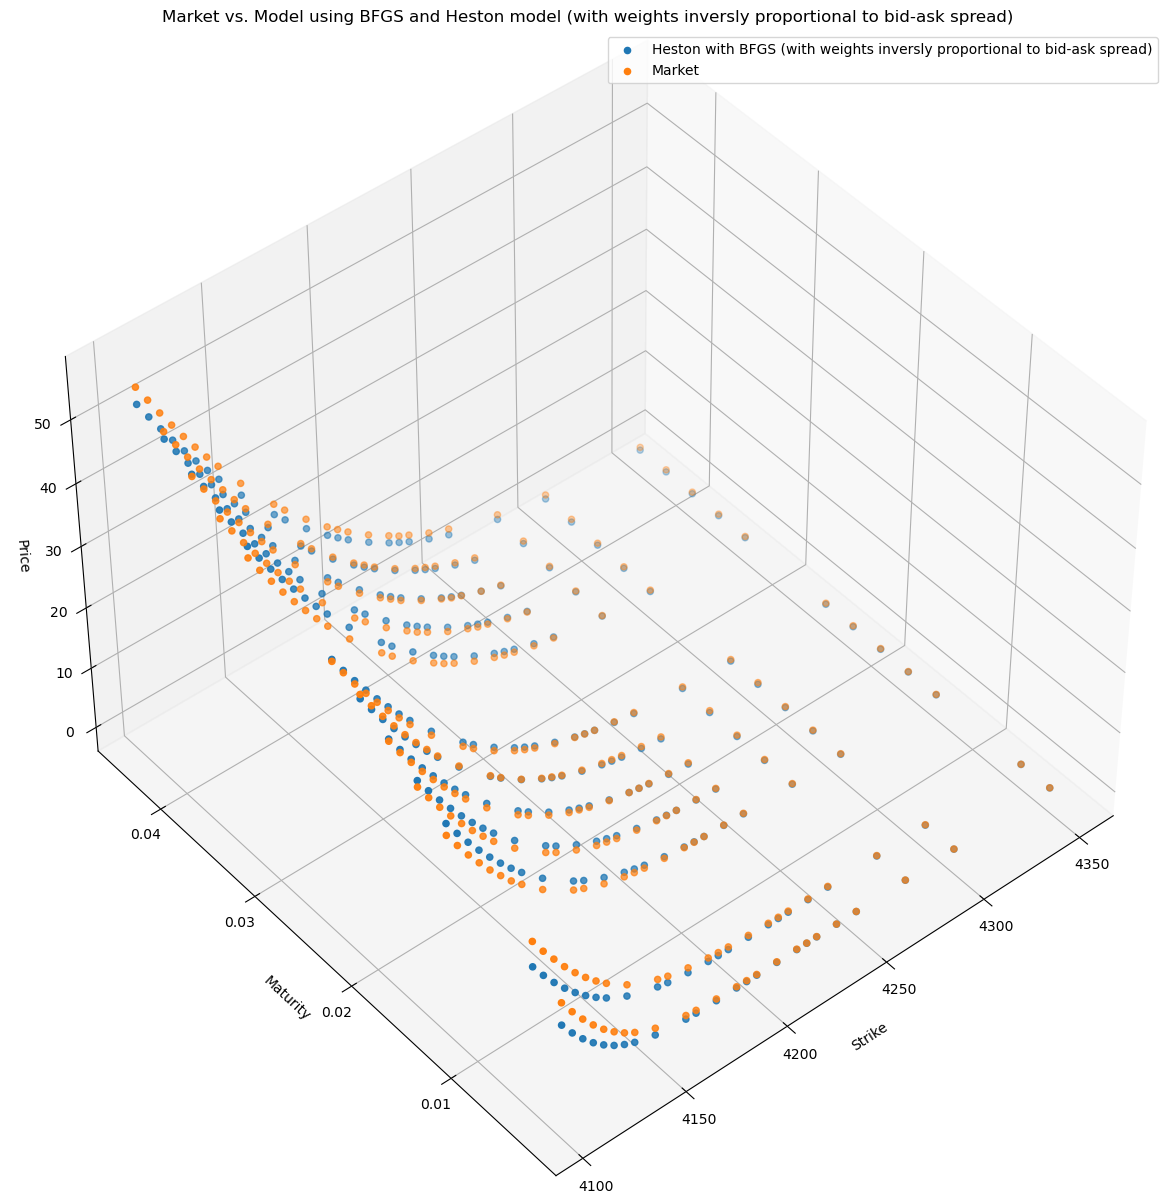

In [35]:
# create a meshgrid of the maturities and strikes
maturities_, strikes_ = np.meshgrid(maturities, strikes)

maturities_flat = maturities_.flatten()
strikes_flat =  strikes_.flatten()
prices_flat =  marketPrices.flatten()


fig = plt.figure(figsize= [15,15])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(strikes_flat, maturities_flat, modelPrices_w.T, label='Heston with BFGS (with weights inversly proportional to bid-ask spread)')
ax.scatter(strikes_, maturities_, marketPrices.T, label='Market')
ax.view_init(elev=45, azim=230)
ax.set_xlabel('Strike')
ax.set_ylabel('Maturity')
ax.set_zlabel('Price')
ax.set_title('Market vs. Model using BFGS and Heston model (with weights inversly proportional to bid-ask spread)')

plt.legend()

plt.show()

## 1.1.c Heston with equal weights on Call & Put prices

In [56]:
params = [ 2.34548424, 0.06375792, 0.59865706, -0.43626748, -0.95937438]
# Parameters
alpha = 1.5
eta = 0.2
n = 12

r = 0.0485
q = 0.03310264838967327

model ='Heston'

def callbackF_full(xi):
    global num_iter
    global arg
    print(' ')
    print('i = ' + str(num_iter))
    print('x_i = ' + str(xi))
    print('f_i = ' + str(mfc.eValuefull(xi, *arg)))
    num_iter += 1

arg = (marketPrices,marketPrices_p,maturities,maturities_p,strikes,strikes_p, r, q, S0, alpha, eta, n, model)

num_iter = 1
[xopt_pc, fopt_pc, gopt_pc, Bopt_pc, func_calls_pc, grad_calls_pc, warnflg_pc] = fmin_bfgs(
        mfc.eValuefull,
        params,
        args=arg, 
        fprime=None,
        callback=callbackF_full,
        maxiter=20,
        full_output=True, 
        retall=False)

 
i = 1
x_i = [ 2.3447358   0.02221499  0.59941445 -0.43499828 -1.96851829]
f_i = 1.5661991800769748
 
i = 2
x_i = [ 2.34476321  0.02475845  0.59897878 -0.43470679 -1.96873128]
f_i = 1.5542133829444051
 
i = 3
x_i = [ 2.34485756  0.02488506  0.58390361 -0.4204967  -1.96870217]
f_i = 1.5315870195738324
 
i = 4
x_i = [ 2.34556638  0.002906    0.52496259 -0.41509455 -1.96950069]
f_i = 1.4960547103272772
 
i = 5
x_i = [ 2.3439235   0.00989374  0.4017905  -0.44118824 -1.96898323]
f_i = 1.4424196248814662
 
i = 6
x_i = [ 2.34145541  0.00310946  0.29779279 -0.49082219 -1.96911141]
f_i = 1.427926750328508
 
i = 7
x_i = [ 2.33284992  0.0077059   0.27118038 -0.51096637 -1.96898272]
f_i = 1.4259122046208885
 
i = 8
x_i = [ 2.33272734  0.00774931  0.27159028 -0.51912307 -1.9689911 ]
f_i = 1.425370875633067
 
i = 9
x_i = [ 2.33300477  0.00732287  0.26440363 -0.5419114  -1.96900476]
f_i = 1.4243672662125673
 
i = 10
x_i = [ 2.33405794  0.00673751  0.2457745  -0.59312622 -1.9690082 ]
f_i = 1.42262911

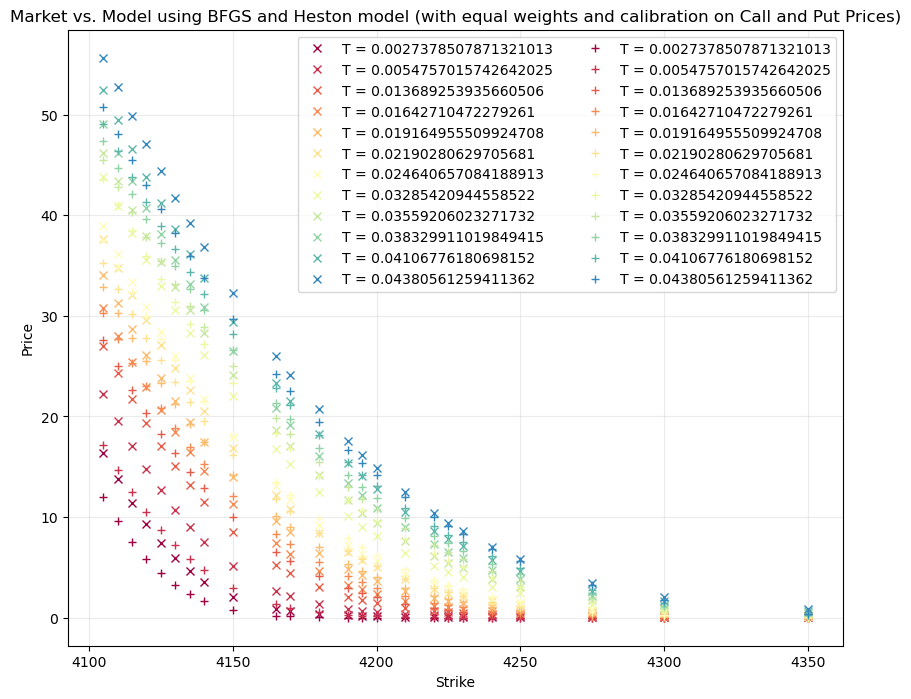

In [57]:
params2 = xopt_pc
lenT = len(maturities)
lenK = len(strikes)
modelPrices_pc = np.zeros((lenT, lenK))

for i in range(lenT):
    for j in range(lenK):
        T = maturities[i]
        K = strikes[j]
        [km, cT_km] = mfc.genericFFT(params2, S0, K, r, q, T, alpha, eta, n, model)
        modelPrices_pc[i,j] = cT_km[0]


# plot
fig = plt.figure(figsize=(10,8))
labels = []
colormap = cm.Spectral
# create a list of colors to cycle through
colors = [colormap(i) for i in np.linspace(0, 0.9, len(maturities))]

#plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, len(maturities))])
plt.gca().set_prop_cycle(color=colors)
for i in range(len(maturities)):
    plt.plot(strikes, marketPrices[i,:], 'x')
    labels.append('T = ' + str(maturities[i]))
    
for i in range(len(maturities)):
    plt.plot(strikes, modelPrices_pc[i,:], '+')
    labels.append('T = ' + str(maturities[i]))
plt.legend(labels, loc='upper right', ncol=2)
plt.grid(alpha=0.25)
plt.xlabel('Strike')
plt.ylabel('Price')
plt.title('Market vs. Model using BFGS and Heston model (with equal weights and calibration on Call and Put Prices)')
#plt.savefig('MarketvsModel_BFGS.png')
plt.show() 


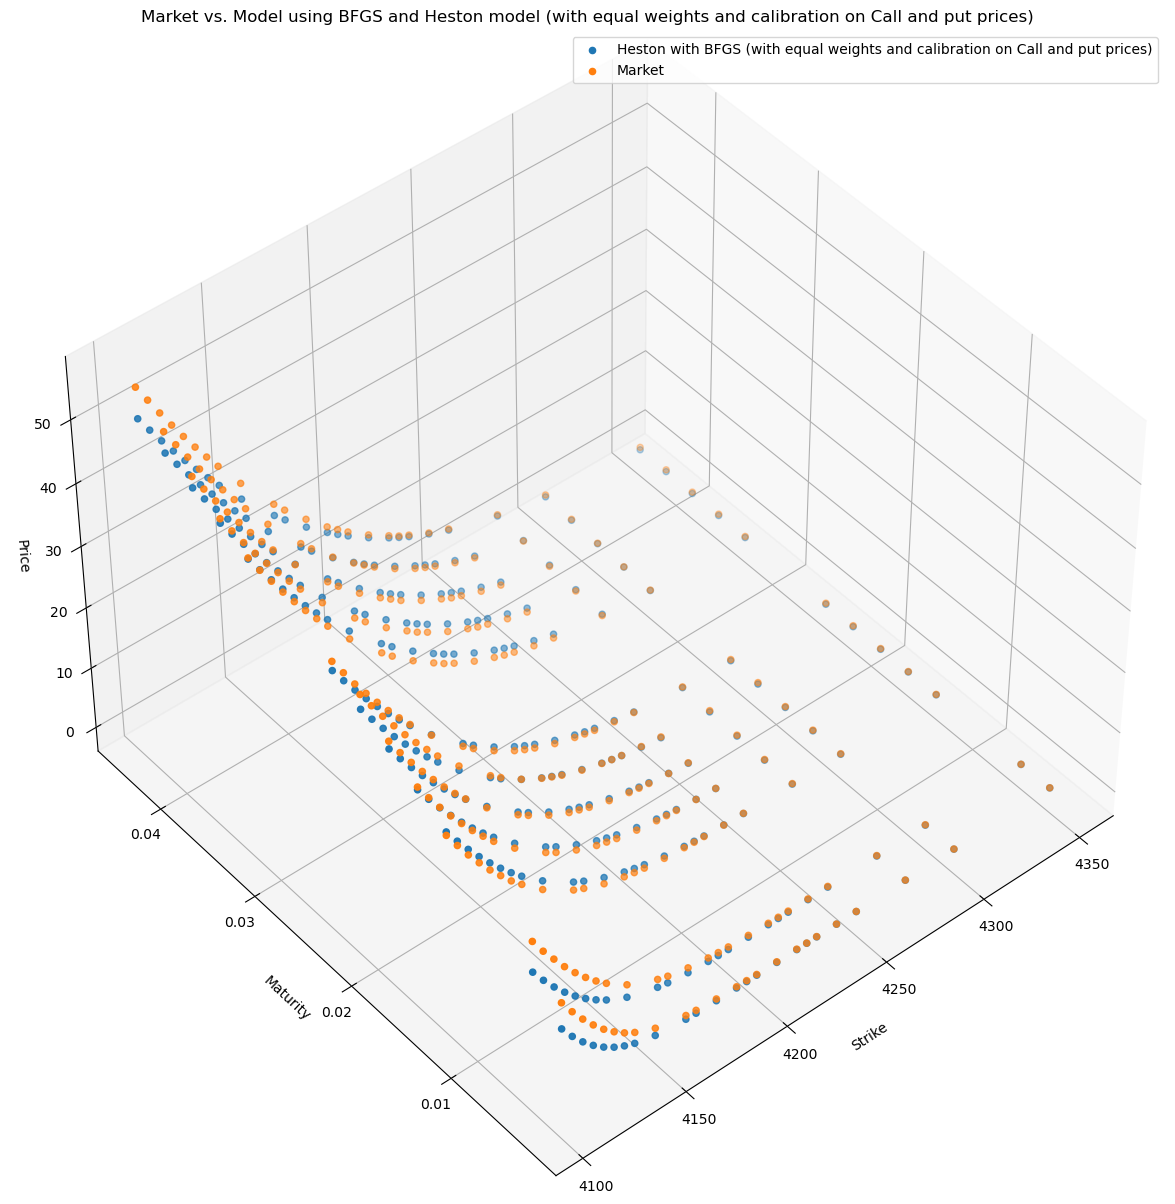

In [58]:
# create a meshgrid of the maturities and strikes
maturities_, strikes_ = np.meshgrid(maturities, strikes)

maturities_flat = maturities_.flatten()
strikes_flat =  strikes_.flatten()
prices_flat =  marketPrices.flatten()


fig = plt.figure(figsize= [15,15])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(strikes_flat, maturities_flat, modelPrices_pc.T, label='Heston with BFGS (with equal weights and calibration on Call and put prices)')
ax.scatter(strikes_, maturities_, marketPrices.T, label='Market')
ax.view_init(elev=45, azim=230)
ax.set_xlabel('Strike')
ax.set_ylabel('Maturity')
ax.set_zlabel('Price')
ax.set_title('Market vs. Model using BFGS and Heston model (with equal weights and calibration on Call and put prices)')

plt.legend()

plt.show()

## 1.1.d Heston with weights inversely proportional to bid-ask spread on Call & Put prices

In [37]:
params = [ 2.34548424, 0.06375792, 0.59865706, -0.43626748, -0.95937438]

# Parameters
alpha = 1.5
eta = 0.2
n = 12

model ='Heston'

def callbackF_full_w(xi):
    global num_iter
    global arg
    print(' ')
    print('i = ' + str(num_iter))
    print('x_i = ' + str(xi))
    print('f_i = ' + str(mfc.eValuefull_w(xi, *arg)))
    num_iter += 1

arg = (marketPrices,marketPrices_p,maturities,maturities_p,strikes,strikes_p, r, q, S0, alpha, eta, n, model, w, w_p)

num_iter = 1
[xopt_pc_w, fopt_pc_w, gopt_pc_w, Bopt_pc_w, func_calls_pc_w, grad_calls_pc_w, warnflg_pc_w] = fmin_bfgs(
        mfc.eValuefull_w,
        params,
        args=arg, 
        fprime=None,
        callback=callbackF_full_w,
        maxiter=20,
        full_output=True, 
        retall=False)

 
i = 1
x_i = [ 2.34473231  0.02188034  0.59902557 -0.43505844 -1.96850475]
f_i = 3.7476598839823825
 
i = 2
x_i = [ 2.34476937  0.02490873  0.598452   -0.43465567 -1.96873125]
f_i = 3.7269846428427282
 
i = 3
x_i = [ 2.34494357  0.02258822  0.58369952 -0.4214252  -1.96880045]
f_i = 3.6876126530345936
 
i = 4
x_i = [ 2.34558274  0.01483296  0.56709403 -0.42695018 -1.96908605]
f_i = 3.664858356779808
 
i = 5
x_i = [ 2.34988869e+00  2.34350389e-03  4.30194654e-01 -4.80948467e-01
 -1.96936584e+00]
f_i = 3.5443370270032903
 
i = 6
x_i = [ 2.35036968e+00 -7.80836246e-04  3.99250684e-01 -4.99113863e-01
 -1.96944498e+00]
f_i = 3.5277128188278115
 
i = 7
x_i = [ 2.35023479e+00 -5.25435862e-04  3.45909963e-01 -5.27570526e-01
 -1.96935319e+00]
f_i = 3.4978309740524143
 
i = 8
x_i = [ 2.35240520e+00 -8.16625146e-04  2.06099260e-01 -6.18001114e-01
 -1.96917950e+00]
f_i = 3.4786478881377514
 
i = 9
x_i = [ 2.35558803e+00  7.70371583e-04  2.65127885e-01 -5.78650337e-01
 -1.96923383e+00]
f_i = 3.4730

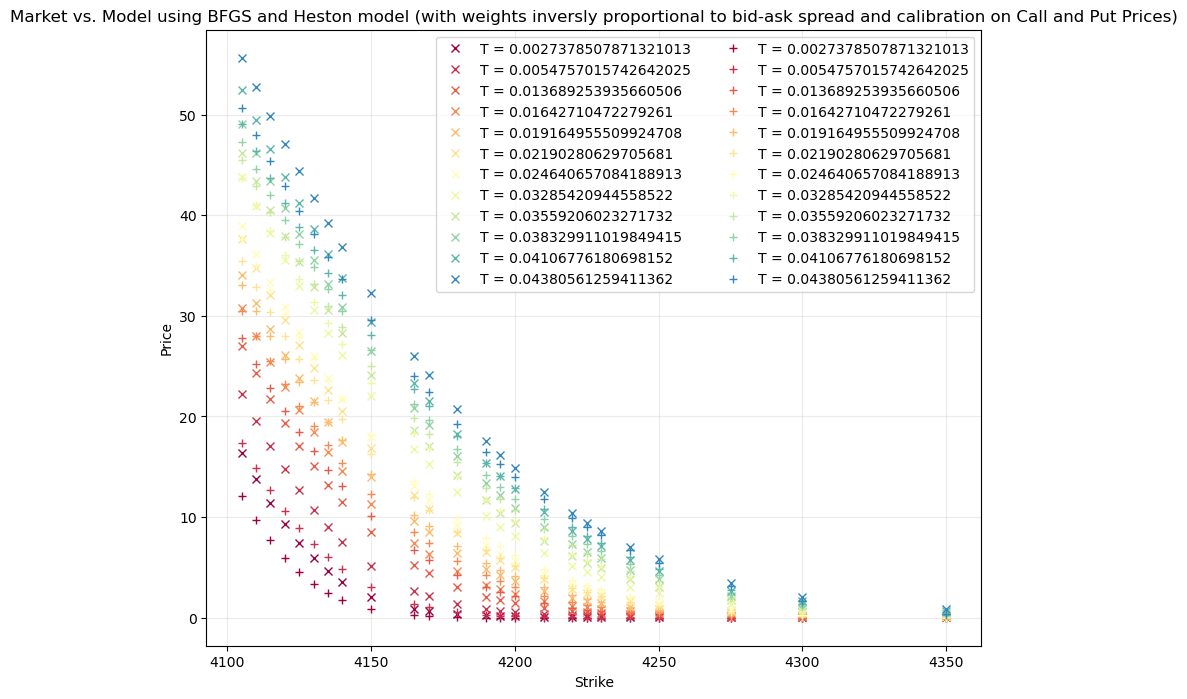

In [39]:
params2 = xopt_pc_w
lenT = len(maturities)
lenK = len(strikes)
modelPrices_pc_w = np.zeros((lenT, lenK))

for i in range(lenT):
    for j in range(lenK):
        T = maturities[i]
        K = strikes[j]
        [km, cT_km] = mfc.genericFFT(params2, S0, K, r, q, T, alpha, eta, n, model)
        modelPrices_pc_w[i,j] = cT_km[0]


# plot
fig = plt.figure(figsize=(10,8))
labels = []
colormap = cm.Spectral
# create a list of colors to cycle through
colors = [colormap(i) for i in np.linspace(0, 0.9, len(maturities))]

#plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, len(maturities))])
plt.gca().set_prop_cycle(color=colors)
for i in range(len(maturities)):
    plt.plot(strikes, marketPrices[i,:], 'x')
    labels.append('T = ' + str(maturities[i]))
    
for i in range(len(maturities)):
    plt.plot(strikes, modelPrices_pc_w[i,:], '+')
    labels.append('T = ' + str(maturities[i]))
plt.legend(labels, loc='upper right', ncol=2)
plt.grid(alpha=0.25)
plt.xlabel('Strike')
plt.ylabel('Price')
plt.title('Market vs. Model using BFGS and Heston model (with weights inversly proportional to bid-ask spread and calibration on Call and Put Prices)')
#plt.savefig('MarketvsModel_BFGS.png')
plt.show() 

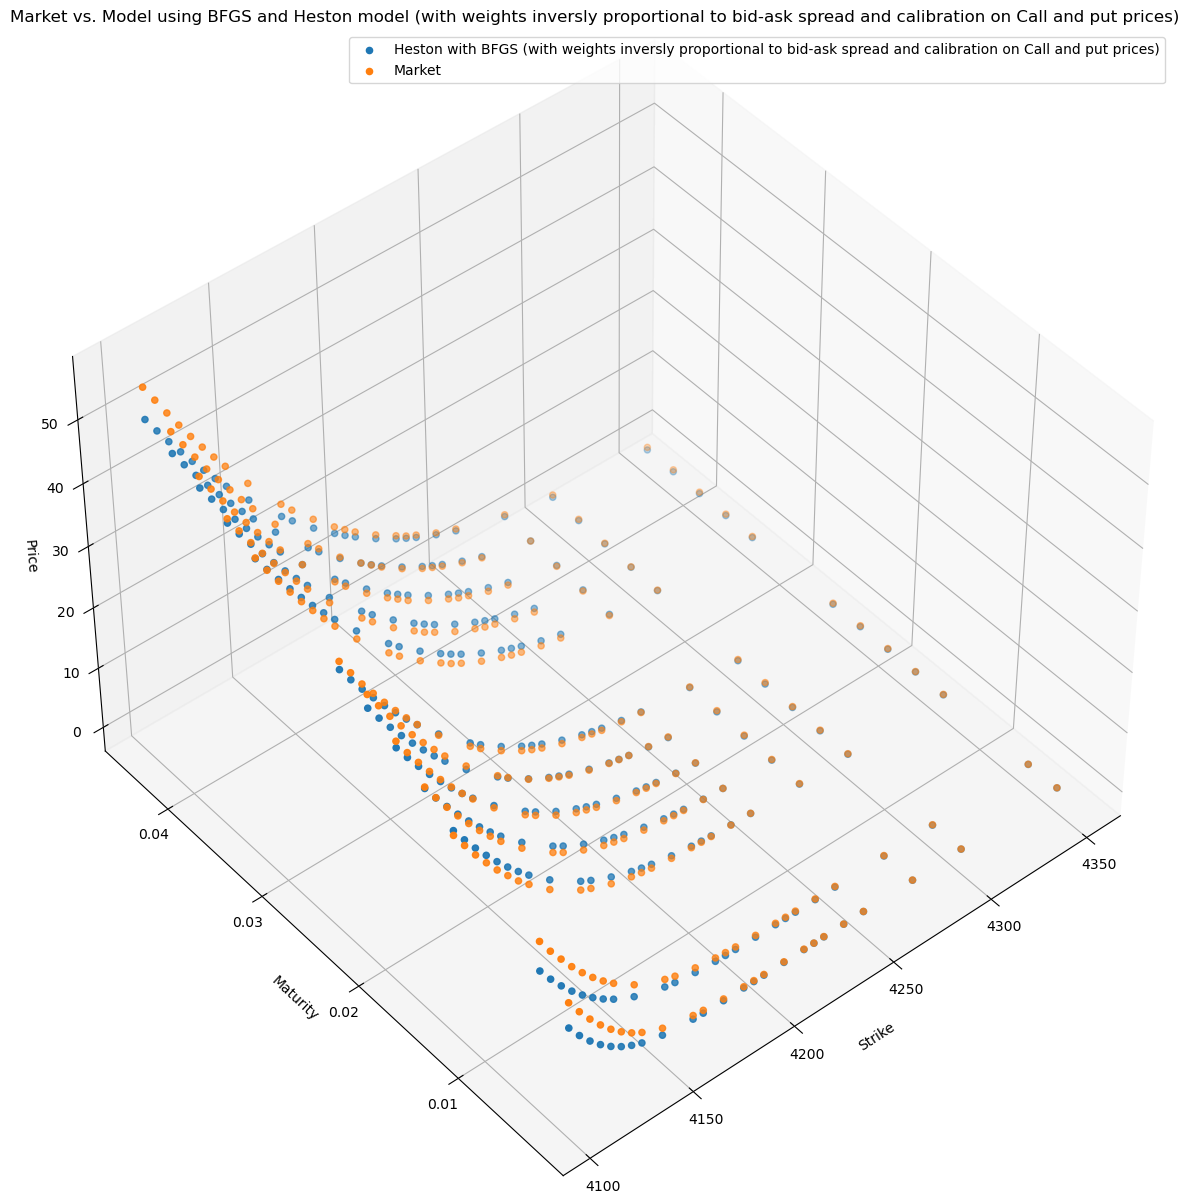

In [40]:
# create a meshgrid of the maturities and strikes
maturities_, strikes_ = np.meshgrid(maturities, strikes)

maturities_flat = maturities_.flatten()
strikes_flat =  strikes_.flatten()
prices_flat =  marketPrices.flatten()


fig = plt.figure(figsize= [15,15])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(strikes_flat, maturities_flat, modelPrices_pc_w.T, label='Heston with BFGS (with weights inversly proportional to bid-ask spread and calibration on Call and put prices)')
ax.scatter(strikes_, maturities_, marketPrices.T, label='Market')
ax.view_init(elev=45, azim=230)
ax.set_xlabel('Strike')
ax.set_ylabel('Maturity')
ax.set_zlabel('Price')
ax.set_title('Market vs. Model using BFGS and Heston model (with weights inversly proportional to bid-ask spread and calibration on Call and put prices)')

plt.legend()

plt.show()

# 1.2 VGSA model:

ΘVGSA = {σ, ν, θ, κ, η, λ}

## 1.2.a VGSA with equal weights on Call Prices

In [42]:
params = [0.0825, 0.8, 0.046, 2.3, 0.8 , 0.9 ]
params = [0.02351992, 0.03838838, 0.00533235, 2.38917246, 1.89090463, 0.84004647]
#params_v = [0.0825, ?, 0.046, 2.3, ? , v0 ]
# Parameters
alpha = 1.5
eta = 0.2
n = 12

model_v = 'VGSA'

def callbackF(xi):
    global num_iter
    global arg
    print(' ')
    print('i = ' + str(num_iter))
    print('x_i = ' + str(xi))
    print('f_i = ' + str(mfc.eValue(xi, *arg)))
    num_iter += 1

arg = (marketPrices, maturities, strikes, r, q, S0, alpha, eta, n, model_v)

num_iter = 1
[xopt_v, fopt_v, gopt_v, Bopt_v, func_calls_v, grad_calls_v, warnflg_v] = fmin_bfgs(
        mfc.eValue,
        params,
        args=arg, 
        fprime=None,
        callback=callbackF,
        maxiter=20,
        full_output=True, 
        retall=False)

1.5517469191298554
1.5517516816292878
1.5517448136637366
1.551751928898251
1.5517469174727627
1.551746919298782
1.5517469191314983
91.19263685241502
91.19263195026973
91.19263147127924
91.19263834490688
91.19263684548315
91.19263686775683
91.19263685019834
15.244038153119996
15.244031180050273
15.244036350867281
15.244040502443315
15.244038151639339
15.244038153640295
15.244038152891749
17.682940592008965
17.682944182897494
17.682940416846993
17.682939297649394
17.682940591814628
17.682940592042637
17.68294059200933
14.929354195559286
14.929345028141041
14.929355120163894
14.92934769727763
14.929354196119041
14.929354195495774
14.929354195569784
1.8637458017866049
1.863736824373112
1.863749508236967
1.8637371731926453
1.863745803750503
1.863745801584812
1.8637458017974315
1.4649454973836897
1.4649456452748921
1.4649454594940508
1.464945884848713
1.4649454969650029
1.4649454974266185
1.4649454973887726
 
i = 1
x_i = [0.02330015 0.03848554 0.00510117 2.38917254 1.89090462 0.84004647]
1.4

In [43]:
xopt_v

array([1.13360207e-02, 8.74206364e-03, 1.21479159e-03, 4.89018747e+00,
       1.76881973e+00, 8.11507721e-01])

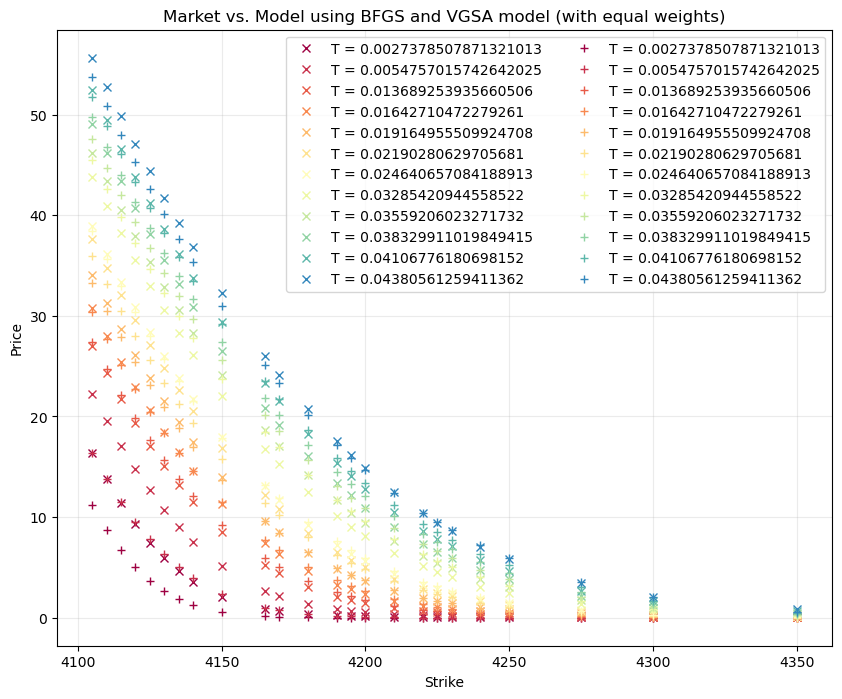

In [44]:
params2 = xopt_v
lenT = len(maturities)
lenK = len(strikes)
modelPrices = np.zeros((lenT, lenK))

for i in range(lenT):
    for j in range(lenK):
        T = maturities[i]
        K = strikes[j]
        [km, cT_km] = mfc.genericFFT(params2, S0, K, r, q, T, alpha, eta, n, model_v)
        modelPrices[i,j] = cT_km[0]


# plot
fig = plt.figure(figsize=(10,8))
labels = []
colormap = cm.Spectral
# create a list of colors to cycle through
colors = [colormap(i) for i in np.linspace(0, 0.9, len(maturities))]

#plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, len(maturities))])
plt.gca().set_prop_cycle(color=colors)
for i in range(len(maturities)):
    plt.plot(strikes, marketPrices[i,:], 'x')
    labels.append('T = ' + str(maturities[i]))
    
for i in range(len(maturities)):
    plt.plot(strikes, modelPrices[i,:], '+')
    labels.append('T = ' + str(maturities[i]))
plt.legend(labels, loc='upper right', ncol=2)
plt.grid(alpha=0.25)
plt.xlabel('Strike')
plt.ylabel('Price')
plt.title('Market vs. Model using BFGS and VGSA model (with equal weights)')
plt.savefig('MarketvsModel_BFGS.png')
plt.show() 


## 1.2.b VGSA with weights inversely proportional to bid-ask spread on Call prices

In [45]:
params = [0.0825, 0.8, 0.046, 2.3, 0.8 , 0.9 ]
params = [0.02351992, 0.03838838, 0.00533235, 2.38917246, 1.89090463, 0.84004647]
#params_v = [0.0825, ?, 0.046, 2.3, ? , v0 ]
# Parameters
alpha = 1.5
eta = 0.2
n = 12

model_v = 'VGSA'

def callbackF_w(xi):
    global num_iter
    global arg
    print(' ')
    print('i = ' + str(num_iter))
    print('x_i = ' + str(xi))
    print('f_i = ' + str(mfc.eValue_w(xi, *arg)))
    num_iter += 1

arg = (marketPrices, maturities, strikes, r, q, S0, alpha, eta, n, model_v, w)

num_iter = 1
[xopt_v_w, fopt_v_w, gopt_v_w, Bopt_v_w, func_calls_v_w, grad_calls_v_w, warnflg_v_w] = fmin_bfgs(
        mfc.eValue_w,
        params,
        args=arg, 
        fprime=None,
        callback=callbackF_w,
        maxiter=20,
        full_output=True, 
        retall=False)

1.4329965669787013
1.4329985934760652
1.4329956655313554
1.4329989520883168
1.4329965660858386
1.4329965670697504
1.4329965669817588
66.5254611459876
66.52545717307594
66.52545708780566
66.52546228167344
66.52546114106296
66.52546115566037
66.52546114451046
6.713050449387529
6.713047379127311
6.713049538190796
6.71305124195713
6.713050448793634
6.713050449567545
6.713050449332572
12.815445626262049
12.81544681472613
12.815445562852469
12.81544528053367
12.815445626202607
12.815445626271606
12.815445626259748
7.572596045206409
7.572588400757418
7.572597509132687
7.572590156157629
7.572596046068241
7.572596045112281
7.57259604521441
1.4310245954499794
1.4310221928021343
1.431025595335581
1.4310227998282679
1.4310245957078702
1.4310245954237113
1.431024595454522
1.3993312199051622
1.3993309758900516
1.3993313137222727
1.3993314612658931
1.3993312196055276
1.399331219935882
1.3993312199090004
 
i = 1
x_i = [0.02332927 0.03847319 0.00510796 2.38917254 1.89090462 0.84004647]
1.39933121990516

## 1.2.c VGSA with equal weights on Call & Put prices

In [55]:
params = [0.0825, 0.8, 0.046, 2.3, 0.8 , 0.9 ]
params = [0.02351992, 0.03838838, 0.00533235, 2.38917246, 1.89090463, 0.84004647]
#params_v = [0.0825, ?, 0.046, 2.3, ? , v0 ]
# Parameters
alpha = 1.5
eta = 0.2
n = 12

model_v = 'VGSA'

def callbackF_full(xi):
    global num_iter
    global arg
    print(' ')
    print('i = ' + str(num_iter))
    print('x_i = ' + str(xi))
    print('f_i = ' + str(mfc.eValuefull(xi, *arg)))
    num_iter += 1

arg = (marketPrices,marketPrices_p,maturities,maturities_p,strikes,strikes_p, r, q, S0, alpha, eta, n, model_v)

num_iter = 1
[xopt_v_pc, fopt_v_pc, gopt_v_pc, Bopt_v_pc, func_calls_v_pc, grad_calls_v_pc, warnflg_v_pc] = fmin_bfgs(
        mfc.eValuefull,
        params,
        args=arg, 
        fprime=None,
        callback=callbackF_full,
        maxiter=20,
        full_output=True, 
        retall=False)

 
i = 1
x_i = [0.02303029 0.03894448 0.00239757 2.3891728  1.8909046  0.84004647]
f_i = 3.0978576486575964
 
i = 2
x_i = [2.62192305e-02 3.82195162e-02 7.88144610e-04 2.38917240e+00
 1.89090464e+00 8.40046465e-01]
f_i = 1.9917768080563152
 
i = 3
x_i = [2.93513053e-02 4.43679557e-02 1.07173304e-03 2.38917625e+00
 1.89090423e+00 8.40046451e-01]
f_i = 1.618442269434726
 
i = 4
x_i = [2.94612050e-02 4.47709473e-02 1.15041444e-03 2.38667322e+00
 1.89144914e+00 8.39826686e-01]
f_i = 1.615396416283285
 
i = 5
x_i = [2.93622737e-02 4.43952706e-02 1.13313070e-03 2.38526728e+00
 1.89174081e+00 8.39565451e-01]
f_i = 1.6145921215856893
 
i = 6
x_i = [2.80703151e-02 4.02935564e-02 1.01023667e-03 2.37127935e+00
 1.89457325e+00 8.36839454e-01]
f_i = 1.609181622999656
 
i = 7
x_i = [2.69824200e-02 3.72147077e-02 9.42659952e-04 2.36069587e+00
 1.89666569e+00 8.34854423e-01]
f_i = 1.6056632468588217
 
i = 8
x_i = [2.60112880e-02 3.47787739e-02 9.02412942e-04 2.35122662e+00
 1.89848176e+00 8.33305500e-0

## 1.2.d VGSA with weights inversely proportional to bid-ask spread on Call & Put prices

In [47]:
params = [0.0825, 0.8, 0.046, 2.3, 0.8 , 0.9 ]
params = [0.02351992, 0.03838838, 0.00533235, 2.38917246, 1.89090463, 0.84004647]
#params_v = [0.0825, ?, 0.046, 2.3, ? , v0 ]
# Parameters
alpha = 1.5
eta = 0.2
n = 12

model_v = 'VGSA'

def callbackF_full_w(xi):
    global num_iter
    global arg
    print(' ')
    print('i = ' + str(num_iter))
    print('x_i = ' + str(xi))
    print('f_i = ' + str(mfc.eValuefull_w(xi, *arg)))
    num_iter += 1

arg = (marketPrices,marketPrices_p,maturities,maturities_p,strikes,strikes_p, r, q, S0, alpha, eta, n, model_v, w, w_p)

num_iter = 1
[xopt_v_w_pc, fopt_v_w_pc, gopt_v_w_pc, Bopt_v_w_pc, func_calls_v_w_pc, grad_calls_v_w_pc, warnflg_v_w_pc] = fmin_bfgs(
        mfc.eValuefull_w,
        params,
        args=arg, 
        fprime=None,
        callback=callbackF_full_w,
        maxiter=20,
        full_output=True, 
        retall=False)

 
i = 1
x_i = [2.31570485e-02 3.89303559e-02 2.21447296e-03 2.38917278e+00
 1.89090460e+00 8.40046470e-01]
f_i = 6.887395668310297
 
i = 2
x_i = [2.63903207e-02 3.79343205e-02 6.58535861e-04 2.38917222e+00
 1.89090465e+00 8.40046466e-01]
f_i = 4.255340803598045
 
i = 3
x_i = [2.89099085e-02 4.23420327e-02 8.84394461e-04 2.38917500e+00
 1.89090436e+00 8.40046459e-01]
f_i = 3.750942690221315
 
i = 4
x_i = [2.88141888e-02 4.17141051e-02 8.09410707e-04 2.39440364e+00
 1.89041640e+00 8.39683082e-01]
f_i = 3.7485753012889886
 
i = 5
x_i = [2.86635478e-02 4.14006573e-02 8.18358278e-04 2.39952107e+00
 1.88994616e+00 8.39334565e-01]
f_i = 3.7461854124484133
 
i = 6
x_i = [2.83170753e-02 4.05242461e-02 8.17799085e-04 2.41295374e+00
 1.88874459e+00 8.38419222e-01]
f_i = 3.7417148360025116
 
i = 7
x_i = [2.76001062e-02 3.86148049e-02 8.01345744e-04 2.44153433e+00
 1.88618070e+00 8.36443988e-01]
f_i = 3.7331835770377007
 
i = 8
x_i = [2.61209461e-02 3.46099653e-02 7.49015100e-04 2.50010640e+00
 1.8

# 1.3 Results of calibration for the different algorihtms:
    

In [59]:
df_param = pd.DataFrame({'Model':['Heston', 'Heston']*2,'Method':['BFGS with equal weights','BFGS with weights inversely proportional to bid-ask spread']*2, 'Prices':['Call']*2+['Call & Put']*2})

list_arg_heston = ['kappa','theta', 'sigma','rho', 'v0']
i=0
for para in list_arg_heston:
    df_param[para] = [xopt[i],xopt_w[i], xopt_pc[i], xopt_pc_w[i]]
    i+=1
    
df_param

Model                                             Method      Prices  \
0  Heston                            BFGS with equal weights        Call   
1  Heston  BFGS with weights inversely proportional to bi...        Call   
2  Heston                            BFGS with equal weights  Call & Put   
3  Heston  BFGS with weights inversely proportional to bi...  Call & Put   

      kappa     theta     sigma       rho        v0  
0  2.273614 -0.048277  0.599988 -0.667367 -0.960299  
1  2.312856 -0.016110  0.600000 -0.653706 -0.958888  
2  2.347618  0.004886  0.150877 -1.000000 -1.969003  
3  3.402906  0.000942  0.157452 -1.001157 -1.969519

In [60]:
df_param_v = pd.DataFrame({'Model':['VGSA', 'VGSA']*2,'Method':['BFGS with equal weights','BFGS with weights inversely proportional to bid-ask spread']*2, 'Prices':['Call']*2+['Call & Put']*2})

list_arg_vgsa = ['sigma','nu','theta','kappa', 'eta', 'lambda']
i=0
for para in list_arg_heston:
    df_param_v[para] = [xopt_v[i],xopt_v_w[i],xopt_v_pc[i],xopt_v_w_pc[i]]
    i+=1
    
df_param_v

Model                                             Method      Prices  \
0  VGSA                            BFGS with equal weights        Call   
1  VGSA  BFGS with weights inversely proportional to bi...        Call   
2  VGSA                            BFGS with equal weights  Call & Put   
3  VGSA  BFGS with weights inversely proportional to bi...  Call & Put   

      kappa     theta     sigma       rho        v0  
0  0.011336  0.008742  0.001215  4.890187  1.768820  
1  0.010598  0.007249  0.000836  4.022125  1.822645  
2  0.017418  0.015838  0.000426  2.107701  1.928858  
3  0.017682  0.015784  0.000337  2.690408  1.878677

### FINDING A STARTING POINT:

In [64]:
iArray = []
rmseArray = []
rmseMin = 1e10

#set 1: promising starting point
params1 = (1.0, 0.02, 0.05, -0.4, 0.08)
params2 = (3.0, 0.06, 0.10, -0.6, 0.04)
# set 2: This one too
#params1 = (6.0, 0.05, 0.04, +0.7, 0.10)
#params2 = (1.0, 0.02, 0.10, -0.8, 0.04)
    
#set 3: tricky starting point
#params1 = (1.0, 0.0625, 0.0125, -0.7, 0.05)
#params2 = (8.0, 0.02,   0.05,   +0.6, 0.12)
    
# set 4: non-informative
params1 = (4.0, 0.05, 0.03, -0.6, 0.10)
params2 = (1.0, 0.10, 0.05, +0.7, 0.05) 

For Heston

In [65]:
model = 'Heston'
for i in mfc.myRange(0, 1, 0.05):
    
    params = i*np.array(params1) + (1.0-i)*np.array(params2)
    iArray.append(i)
     
    rmse = mfc.eValue(params, marketPrices, maturities, strikes, r, q, S0, alpha, eta, n, model)
    rmseArray.append(rmse)
    if (rmse < rmseMin):
        rmseMin = rmse
        optimParams = params

print(rmseMin)
print(optimParams)

13.73884657272789
63.17951580533718
50.69058854836253
32.30626968019369
76.74998986354971
2.155129765013059
68.52641707953879
43.58196469991948
40.000306387478076
71.17226066346362
6.08740112410447
73.56197665180518
35.831860562431864
46.647583702315316
65.16411376863562
8.156468001808166
78.33697594900107
27.474492944196815
52.69782307657868
58.74995409481188
2.155129765013059
[0.5075 0.0775 0.045  3.     1.    ]


For VGSA

In [66]:
iArray = []
rmseArray = []
rmseMin = 1e10
# set 4: non-informative
params1 = (0.3, 0 , 0.05, 4.0, 0.0, 1.0)
params2 = (0.5, 1 , 0.10, 1.0, 1.0, 1.0) 


In [67]:
params = [2.3,     0.046,   0.0825, -0.53,    0.054, ]
params_v = [0.0825, ?, 0.046, 2.3, ? , v0 ]

SyntaxError: invalid syntax (1111113738.py, line 2)

In [ ]:
model = 'VGSA'
for i in mfc.myRange(0, 1, 0.05):
    
    params = i*np.array(params1) + (1.0-i)*np.array(params2)
    iArray.append(i)
     
    rmse = mfc.eValue(params, marketPrices, maturities, strikes, r, q, S0, alpha, eta, n, model)
    rmseArray.append(rmse)
    if (rmse < rmseMin):
        rmseMin = rmse
        optimParams = params

print(rmseMin)
print(optimParams)

# 2. Local volatility surface

In [68]:
def vol_surface(params, strikes, maturities, modelPrices, model, title_):
    Prices = modelPrices.T
    params2 = params
    lenT = 3 * len(maturities)
    lenK = 3 * len(strikes)
    h_strikes = (strikes[-1]*0.95 - strikes[0]) / lenK
    h_maturities = (maturities[-1] - maturities[0]) / lenT
    strikes_l = np.arange(strikes[0]*0.95, strikes[-1] + h_strikes, h_strikes)
    maturities_l = np.arange(maturities[0], maturities[-1] + h_maturities, h_maturities)
    lenT = len(maturities_l)
    lenK = len(strikes_l)
    Prices = np.zeros((lenK, lenT))

    print('Computing the prices according to the model and the opt-parameters')
    for i in tqdm(range(lenK)):
        for j in range(lenT):
            T = maturities_l[j]
            K = strikes_l[i]
            [km, cT_km] = mfc.genericFFT(params2, S0, K, r, q, T, alpha, eta, n, model)
            Prices[i, j] = cT_km[0]

    sig_loc = np.zeros((lenK, lenT))
    print('Computing the local volatility surface')
    for i in tqdm(range(1, lenK - 1)):
        for j in range(1, lenT - 1):
            dC_dt = (Prices[i, j + 1] - Prices[i, j - 1]) / (maturities_l[j + 1] - maturities_l[j - 1])
            dC_dK = (Prices[i + 1, j] - Prices[i - 1, j]) / (strikes_l[i + 1] - strikes_l[i - 1])
            dC2_dK2 = (Prices[i + 1, j] - 2 * Prices[i, j] + Prices[i - 1, j]) / ((strikes_l[i + 1] - strikes_l[i]) * (strikes_l[i] - strikes_l[i - 1]))
            sig_loc[i, j] = np.sqrt(2 * (dC_dt + q * Prices[i, j] + (r - q) * strikes_l[i] * dC_dK) / (strikes_l[i] ** 2 * dC2_dK2))

    print(60 * '=')
    # create a meshgrid of the maturities and strikes
    maturities_, strikes_ = np.meshgrid(maturities_l[1:-1], strikes_l[1:-1])

    sig_loc_ = sig_loc[1:-1, 1:-1]
    print(np.shape(maturities_))
    print(np.shape(sig_loc_))

    # show plot
    fig = plt.figure(figsize=[15, 15])
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(strikes_, maturities_, sig_loc_, cmap='rainbow')#cm.coolwarm, vmin=-1, vmax=1)
    #ax.scatter(strikes_, maturities_, sig_loc_, label='Local Volatility Surface')
    #ax.plot_wireframe(strikes_, maturities_, sig_loc_, label='Local Volatility Surface',cmap=cm.coolwarm)
    ax.view_init(elev=15, azim=160)
    ax.set_xlabel('Strike')
    ax.set_ylabel('Maturity')
    ax.set_zlabel('Local Volatility')
    ax.set_title(title_)

    plt.show()


''' As for the models, the results seem slightly better using with weights inversely proportional to bid-ask spread instead of equal weights, we will plot the local volatility surfaces for both VGSA and Heston model using the parameters obtained with with weights inversely proportional to bid-ask spread.'''

## 2.1 Local Volatility Surface for Heston model

Computing the prices according to the model and the opt-parameters


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1180/1180 [13:35<00:00,  1.45it/s]


Computing the local volatility surface


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1178/1178 [00:00<00:00, 3441.95it/s]


(1178, 36)
(1178, 36)


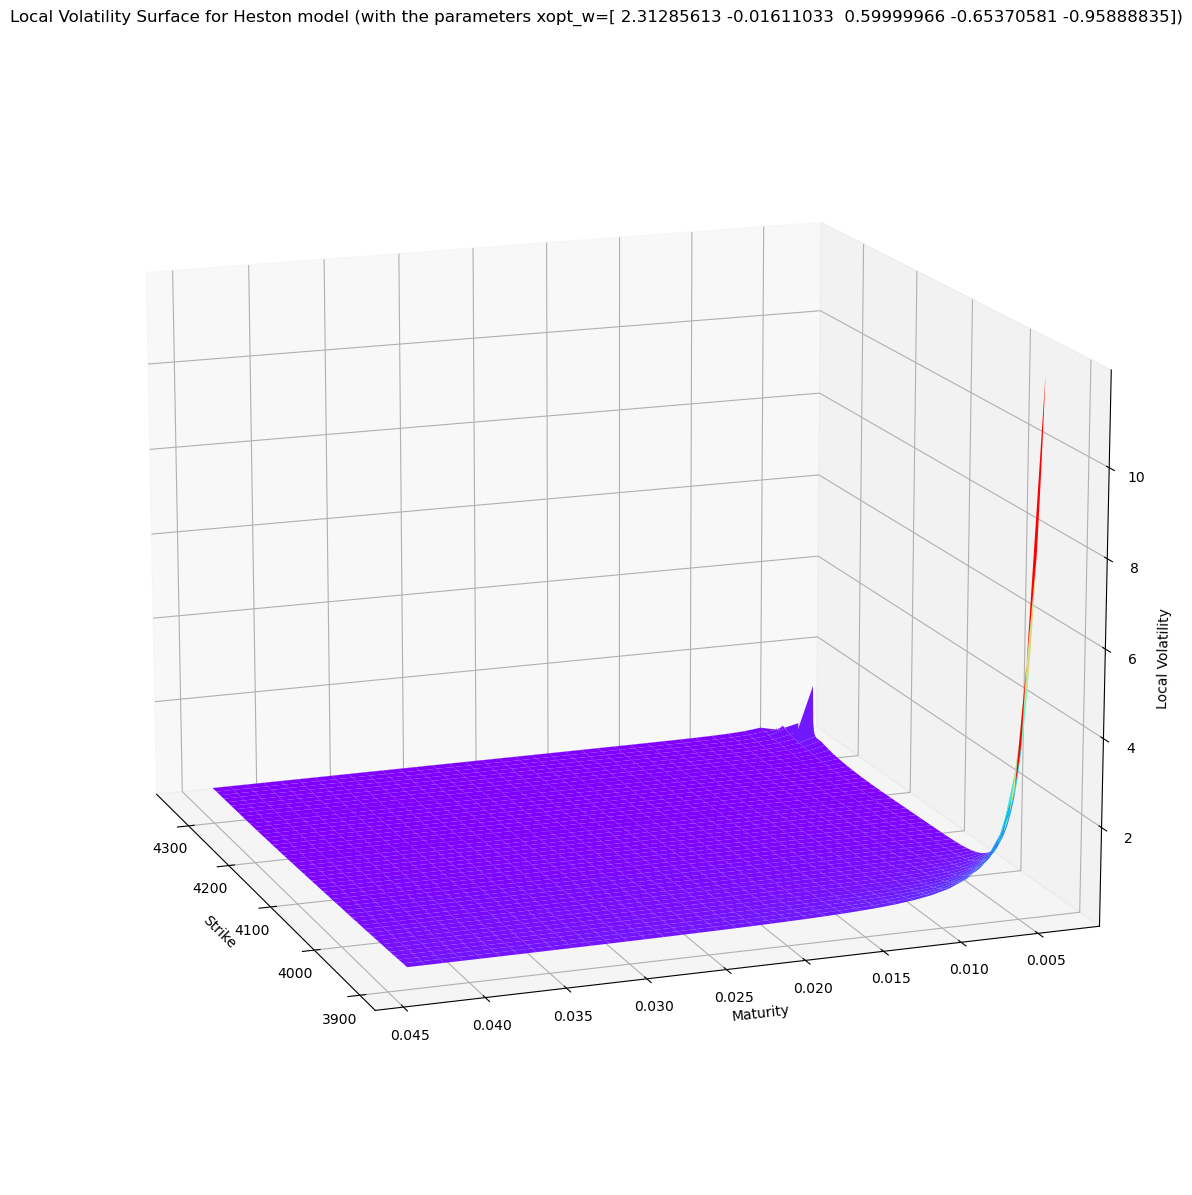

In [69]:
params_ = xopt_w
model_ = 'Heston'
title_ = f'Local Volatility Surface for Heston model (with the parameters xopt_w={xopt_w})'
vol_surface(params_,strikes,maturities,modelPrices,model_, title_)

Computing the prices according to the model and the opt-parameters


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 73/73 [00:46<00:00,  1.57it/s]


Computing the local volatility surface


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 3798.66it/s]


(71, 36)
(71, 36)


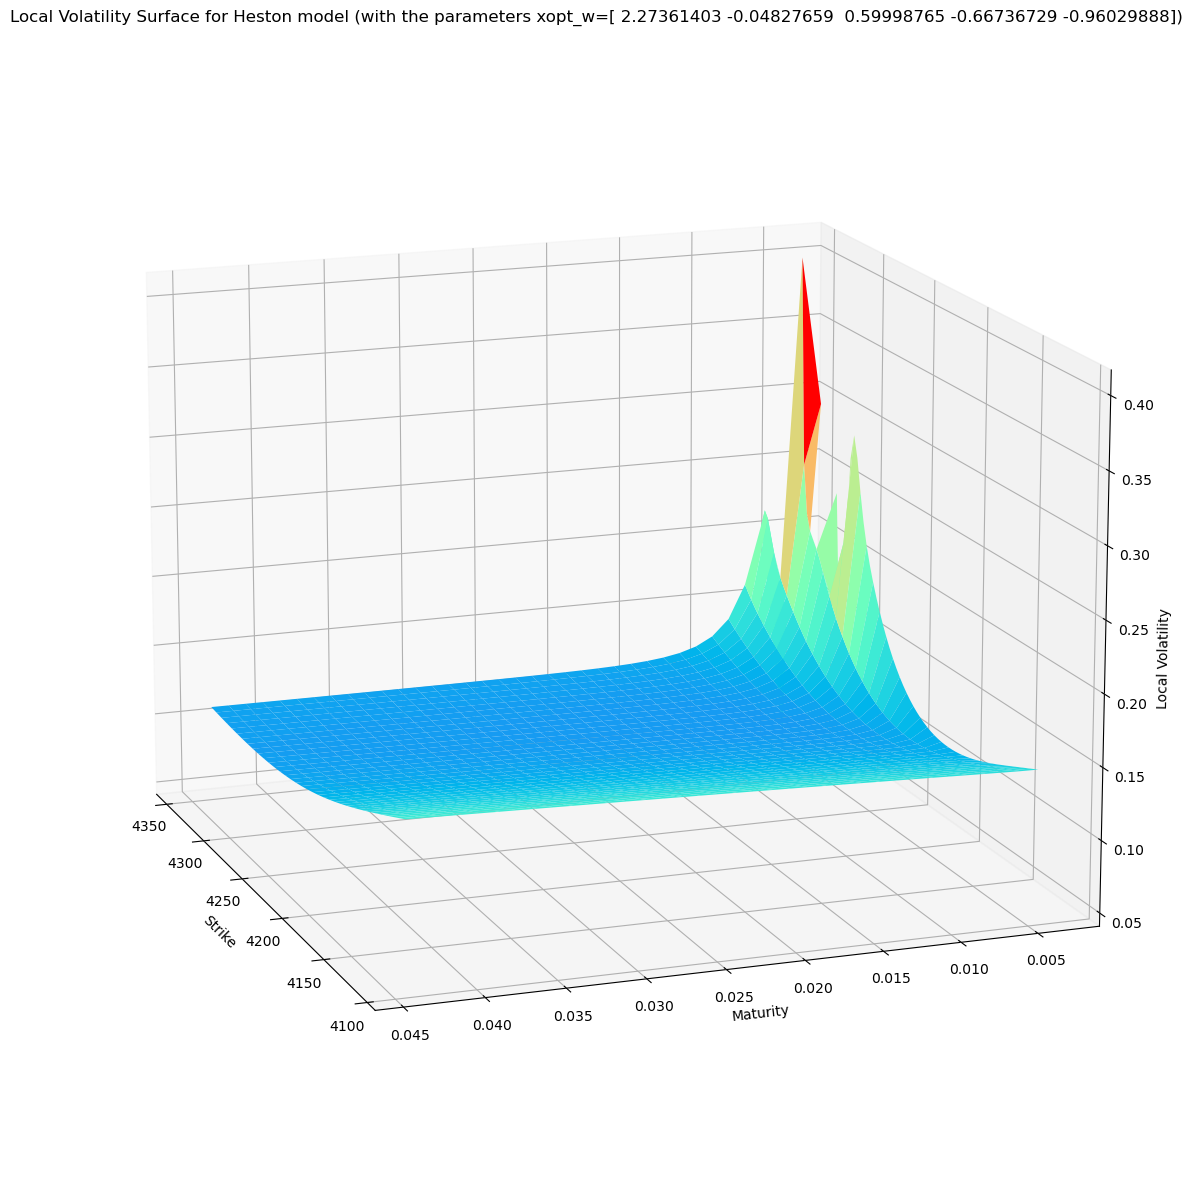

In [50]:
params_ = xopt
model_ = 'Heston'
title_ = f'Local Volatility Surface for Heston model (with the parameters xopt_w={xopt})'
vol_surface(params_,strikes,maturities,modelPrices,model_, title_)

Computing the prices according to the model and the opt-parameters


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 73/73 [00:46<00:00,  1.55it/s]


Computing the local volatility surface


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 3809.39it/s]


(71, 36)
(71, 36)


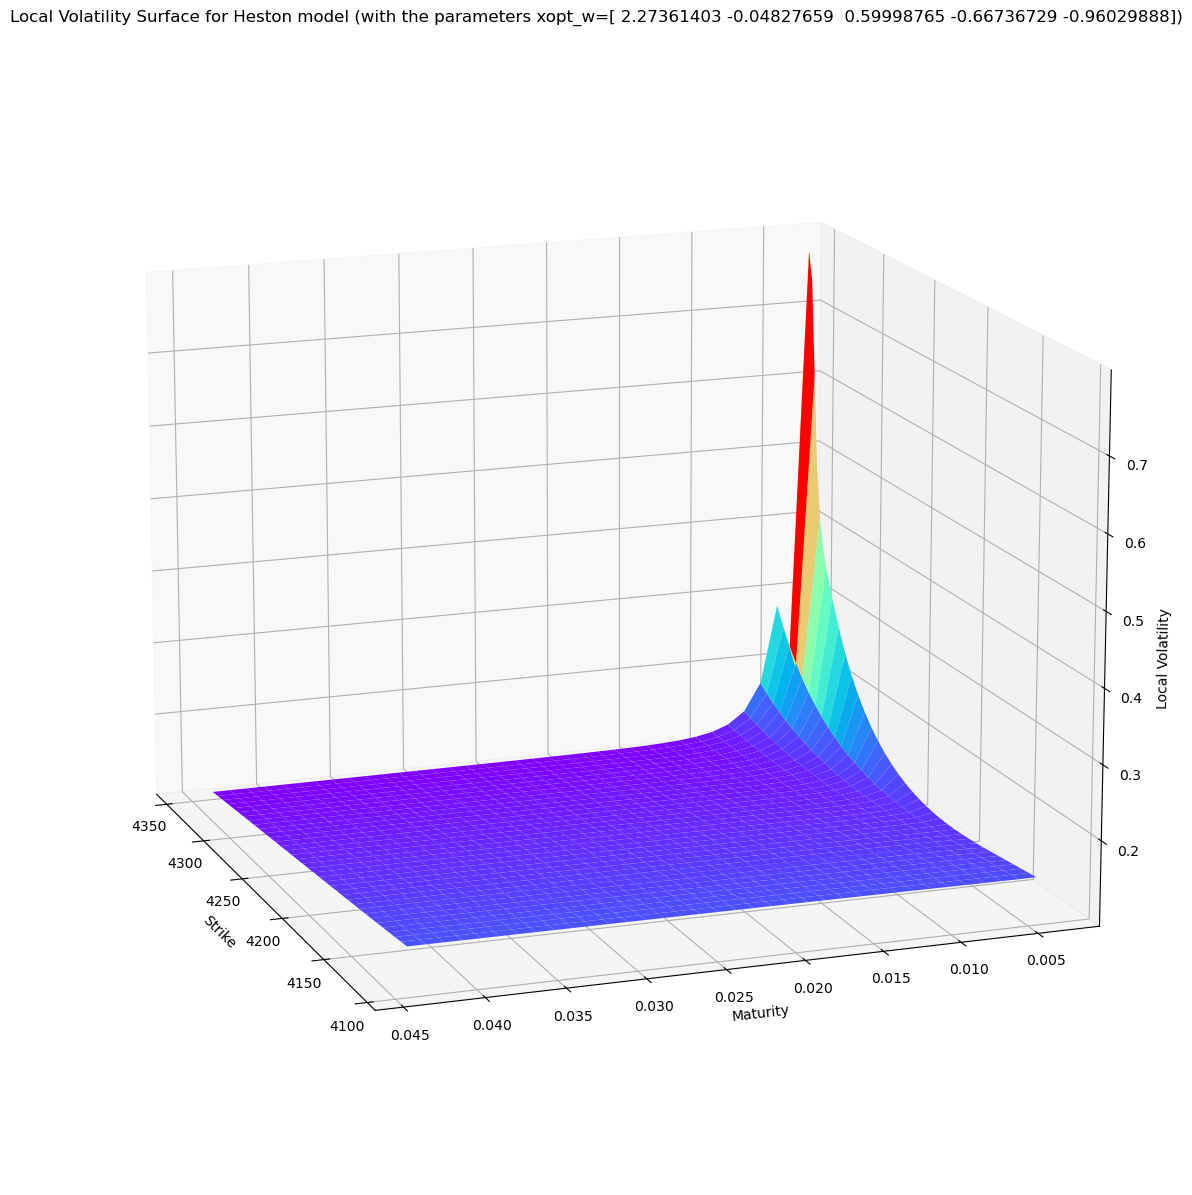

In [62]:
params_ = xopt_pc
model_ = 'Heston'
title_ = f'Local Volatility Surface for Heston model (with the parameters xopt_w={xopt})'
vol_surface(params_,strikes,maturities,modelPrices,model_, title_)

Computing the prices according to the model and the opt-parameters


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 73/73 [00:50<00:00,  1.45it/s]


Computing the local volatility surface


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 4128.42it/s]


(71, 36)
(71, 36)


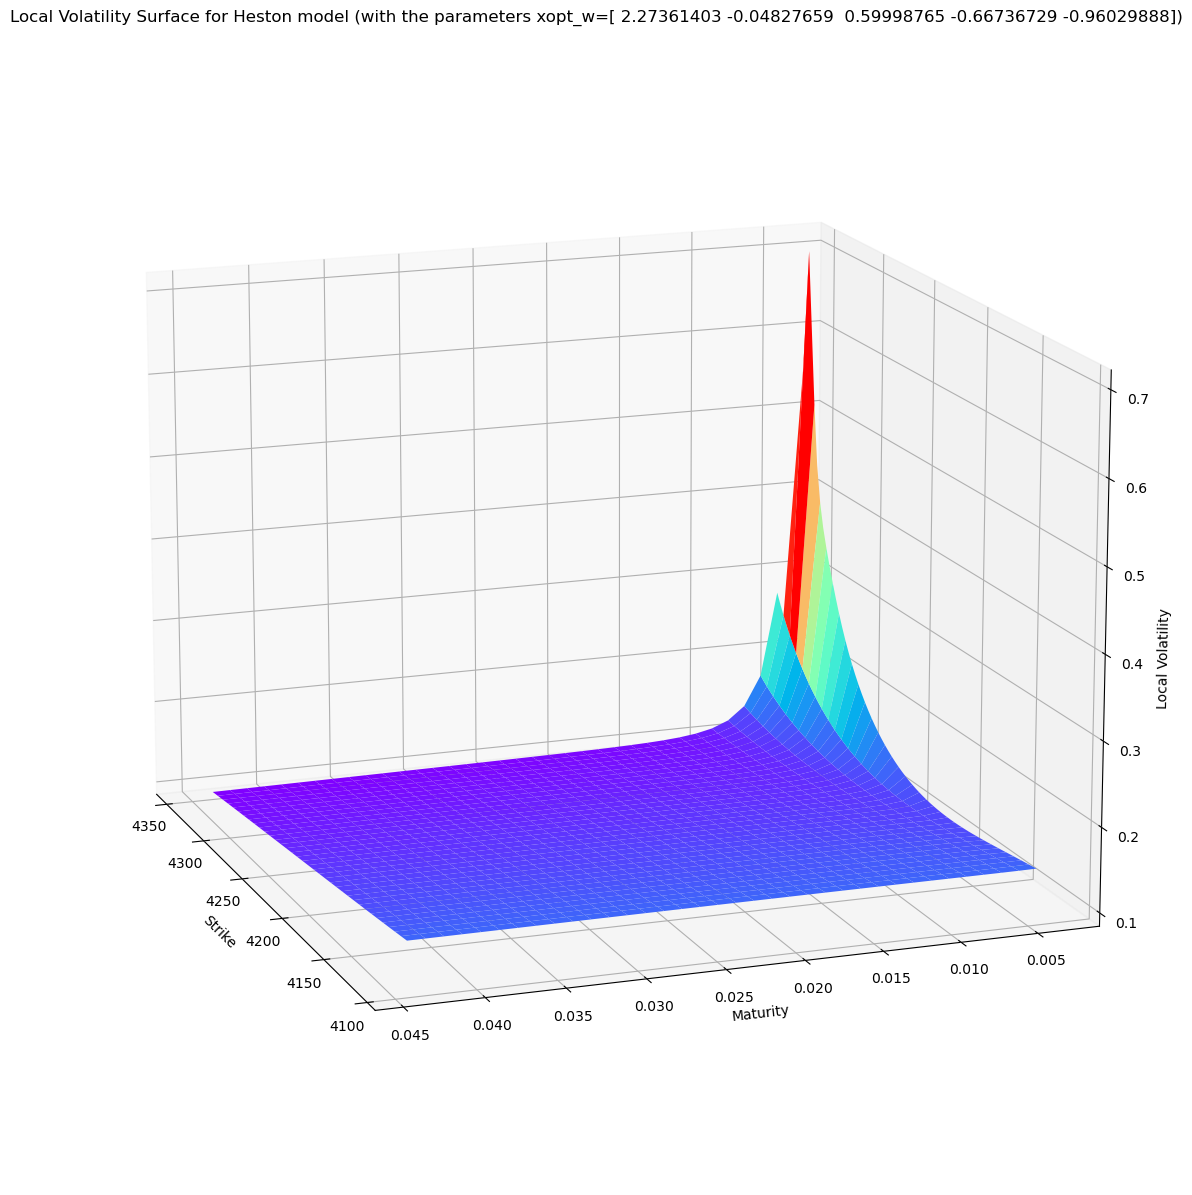

In [63]:
params_ = xopt_pc_w
model_ = 'Heston'
title_ = f'Local Volatility Surface for Heston model (with the parameters xopt_w={xopt})'
vol_surface(params_,strikes,maturities,modelPrices,model_, title_)

## 2.2 Local Volatility Surface for VGSA model

Computing the prices according to the model and the opt-parameters


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 73/73 [00:52<00:00,  1.38it/s]


Computing the local volatility surface


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 2355.75it/s]


(71, 36)
(71, 36)


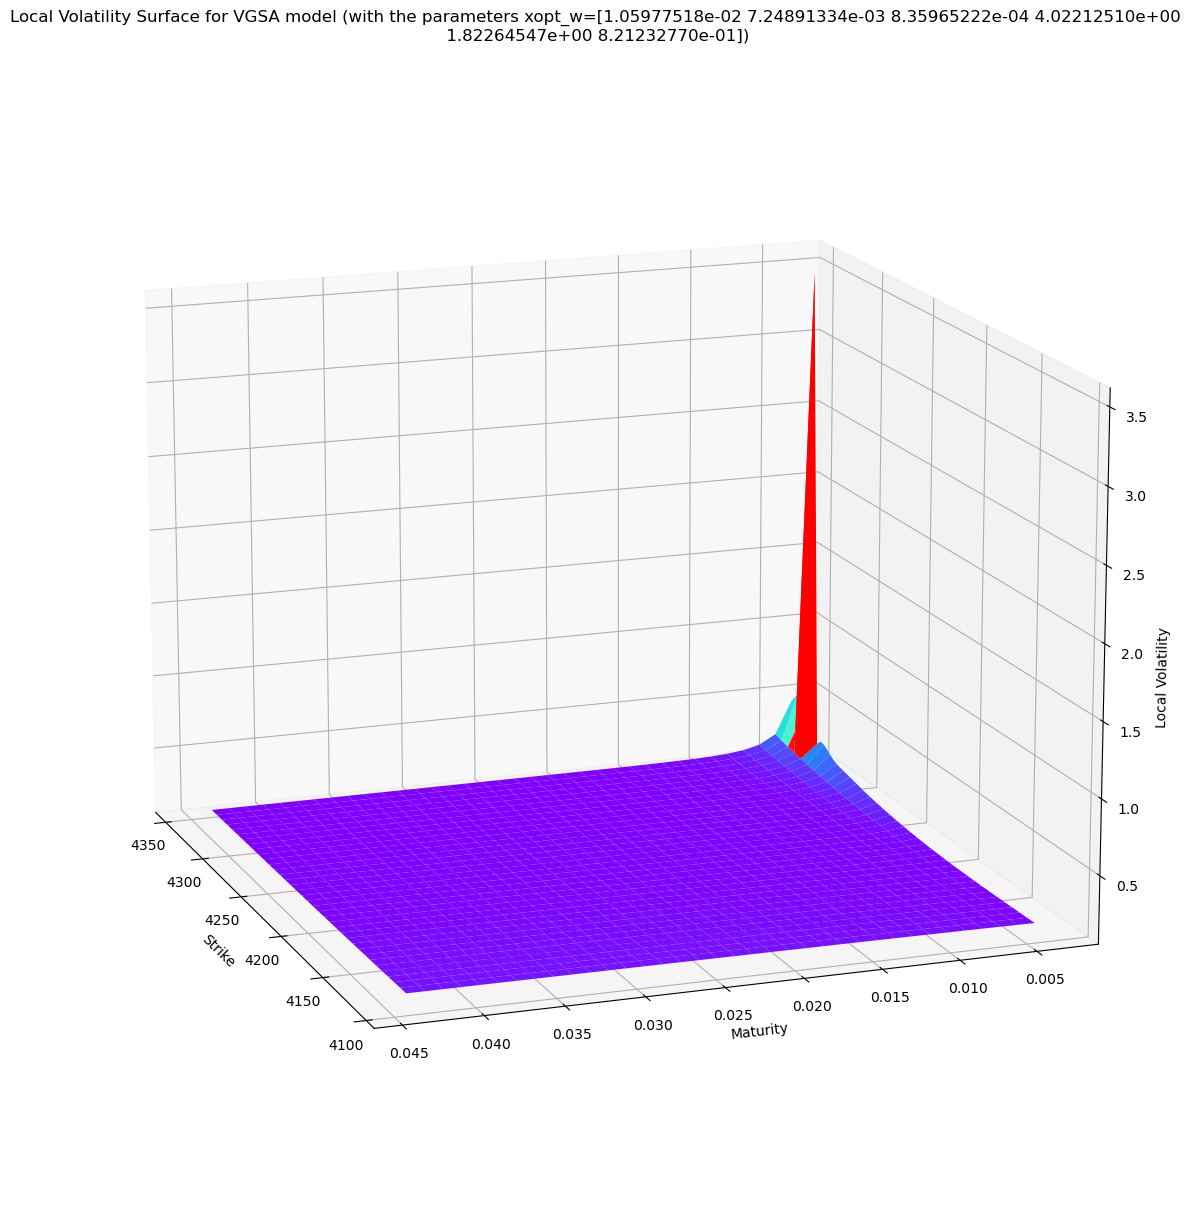

In [51]:
params_ = xopt_v_w
model_ = 'VGSA'
title_ = f'Local Volatility Surface for {model_} model (with the parameters xopt_w={params_})'
vol_surface(params_,strikes,maturities,modelPrices,model_, title_)

Computing the prices according to the model and the opt-parameters


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 73/73 [00:53<00:00,  1.37it/s]


Computing the local volatility surface


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 3912.70it/s]


(71, 36)
(71, 36)


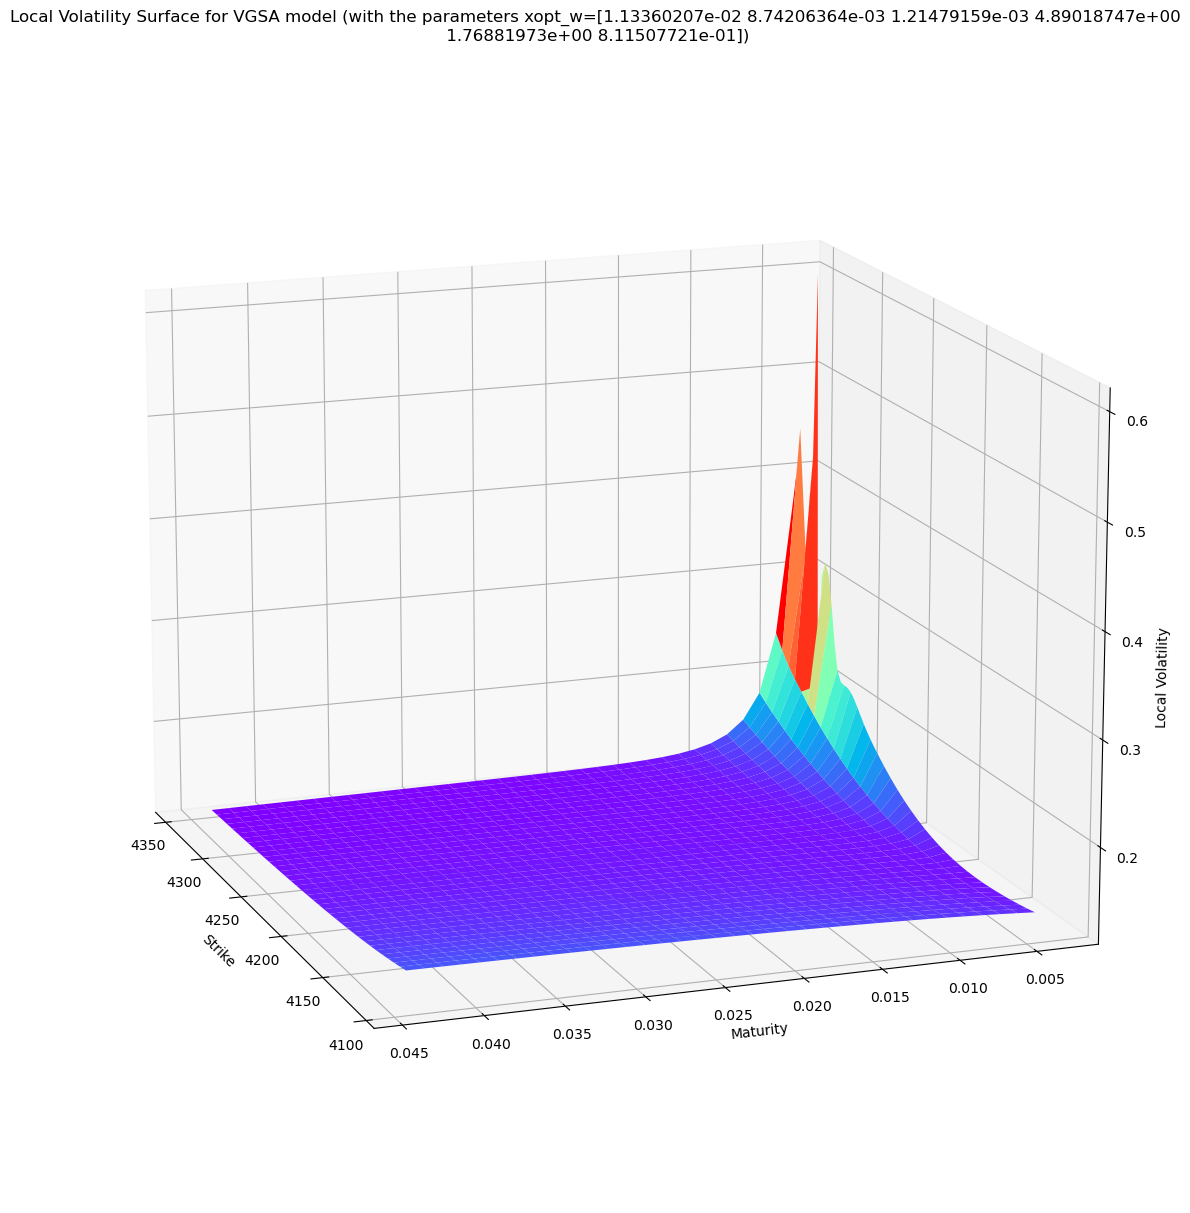

In [52]:
params_ = xopt_v
model_ = 'VGSA'
title_ = f'Local Volatility Surface for {model_} model (with the parameters xopt_w={params_})'
vol_surface(params_,strikes,maturities,modelPrices,model_, title_)

Computing the prices according to the model and the opt-parameters


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 73/73 [00:47<00:00,  1.55it/s]


Computing the local volatility surface


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 2773.11it/s]


(71, 36)
(71, 36)


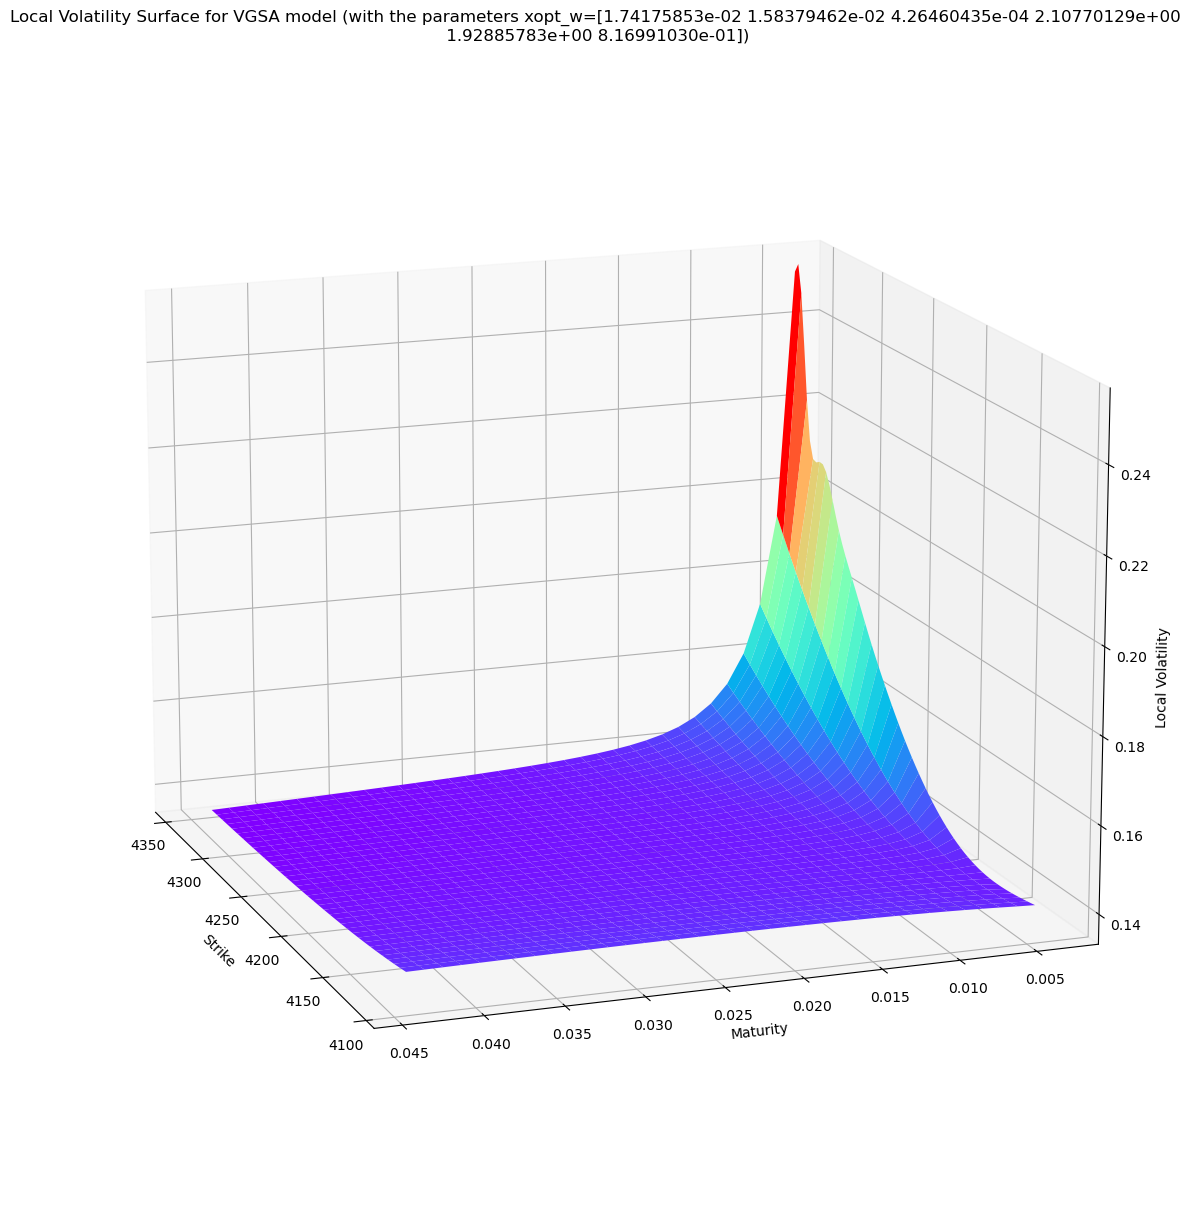

In [61]:
params_ = xopt_v_pc
model_ = 'VGSA'
title_ = f'Local Volatility Surface for {model_} model (with the parameters xopt_w={params_})'
vol_surface(params_,strikes,maturities,modelPrices,model_, title_)

Computing the prices according to the model and the opt-parameters


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 73/73 [00:50<00:00,  1.44it/s]


Computing the local volatility surface


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 3724.07it/s]


(71, 36)
(71, 36)


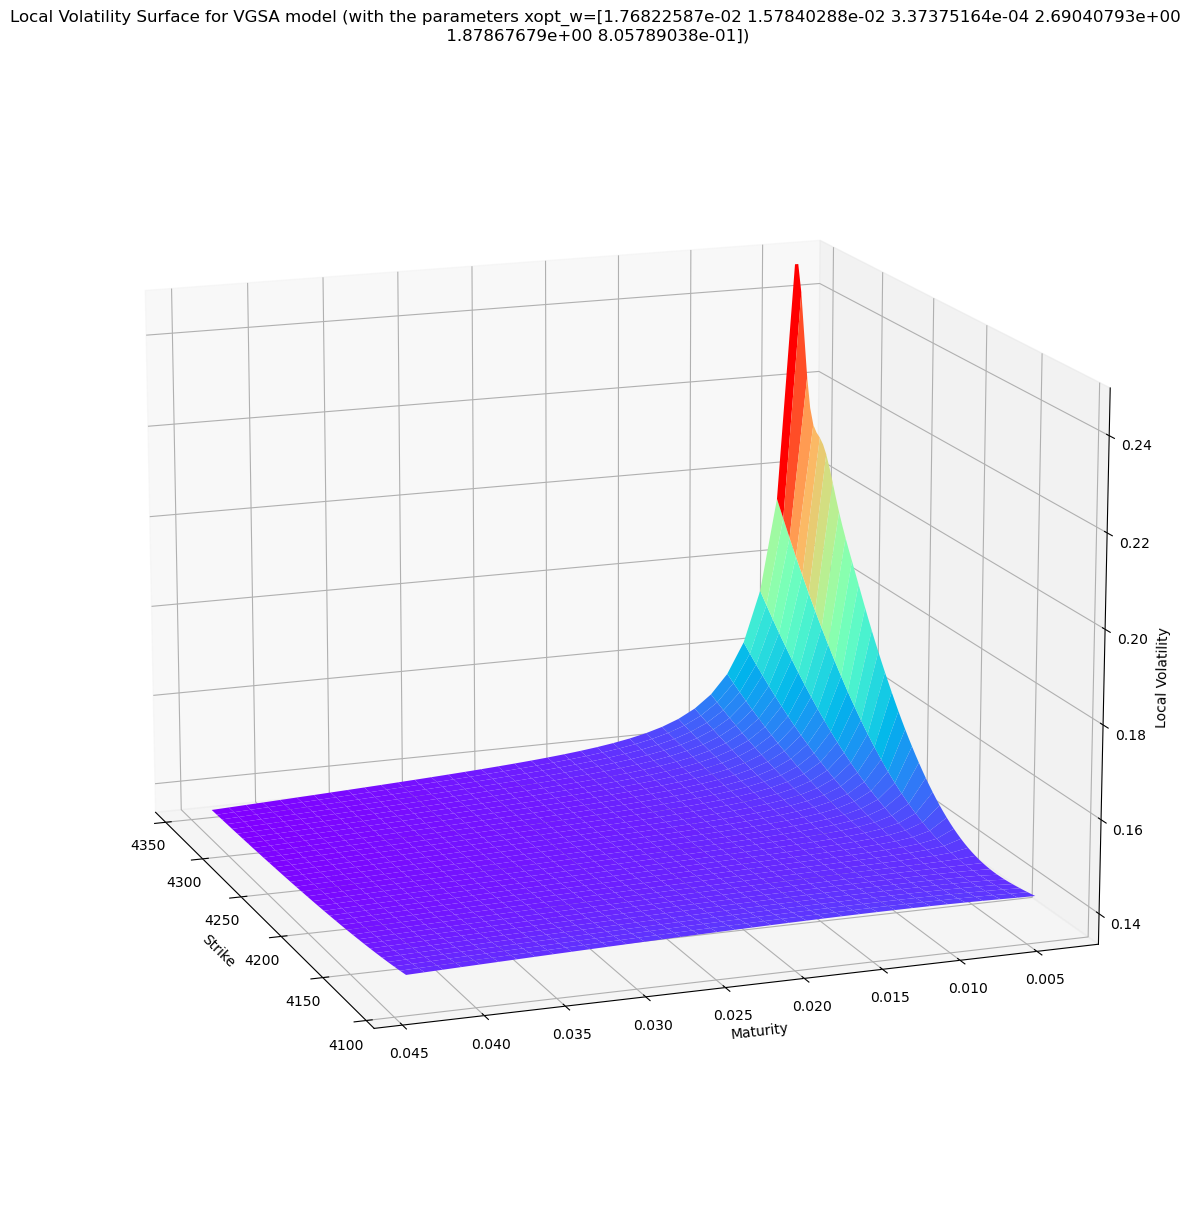

In [53]:
params_ = xopt_v_w_pc
model_ = 'VGSA'
title_ = f'Local Volatility Surface for {model_} model (with the parameters xopt_w={params_})'
vol_surface(params_,strikes,maturities,modelPrices,model_, title_)

# 3. Findings/Observations

Write down your findings/observations on comparing the local volatility surface implied from Heston call surface with the one implied form VGSA call surface

test: 

The Heston model assumes a constant correlation between the underlying asset and volatility, while the VGSA model allows for a varying correlation. This results in differences in the local volatility surface between the two models.

The VGSA model is more flexible than the Heston model in terms of fitting market data. It can capture different shapes and behaviors of the implied volatility surface more accurately.

The VGSA model may produce a smoother local volatility surface compared to the Heston model, which can exhibit more volatility and fluctuations.

The VGSA model may produce a more accurate and stable pricing of exotic options with complex payoff structures, as it can capture the non-normality and skewness of the underlying asset.

The Heston model is widely used in practice due to its simplicity and easy calibration to market data, while the VGSA model may require more computational resources and expertise in model calibration.

Overall, the choice between the Heston and VGSA models depends on the specific application and requirements of the user, as well as the availability and quality of market data.





Regenerate response